## INTRODUCTION 
Notre tâche vise aider les services RH à comprendre et à prevenir l'attrition des employés sur la base d'informations disponibles.  

Question de recherche :  
Comment identifier et prédire avec suffisamment de présicion les départs des employés de l'entreprise?   

Nous analyserons les données des employés afin de pouvoir détecter les profils succeptible au turn-over(départ) ou non par une  application ML capable de prédire si un employé présente une forte propension à la démission.

Techniquement, c'est une tâche de ML supervisée aka Classification binaire.

## IMPORTATION DES LIBRARIES   

In [1]:
# importer les bibliothèques
#%pip install --upgrade numpy pandas matplotlib seaborn scikit-learn nltk joblib tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
tqdm.pandas()
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso


## Importation des données , jointures des tables  et aperçu

In [2]:
# 1. Chargement des données
df_eval = pd.read_csv('../Datasets/extrait_eval.csv')
df_sirh = pd.read_csv('../Datasets/extrait_sirh.csv')
df_sondage = pd.read_csv('../Datasets/extrait_sondage.csv')

# 2. Normalisation des clés de jointure vers un format entier (int)
# On retire le préfixe 'E_' et on convertit
df_eval['id_common'] = df_eval['eval_number'].str.replace('E_', '').astype(int)

# renommer la La colonne id_employee est déjà propre, pour la cohérence
df_sirh = df_sirh.rename(columns={'id_employee': 'id_common'})

# On force la conversion en int pour supprimer les zéros non significatifs (ex: 00001 -> 1)
df_sondage['id_common'] = df_sondage['code_sondage'].astype(int)

# 3. Fusion (Merge) des tables sur la clé commune avec 'inner' join pour ne garder que les employés présents dans les 3 tables
df_master = df_sirh.merge(df_eval, on='id_common', how='inner')\
                   .merge(df_sondage, on='id_common', how='inner')

# Nettoyage des colonnes clés redondantes après fusion
df_master = df_master.drop(columns=['eval_number', 'code_sondage','id_common'])


In [3]:

# Aperçu des données
print(f"Notre table présente {df_master.shape[0]} lignes et {df_master.shape[1]} colonnes")

Notre table présente 1470 lignes et 31 colonnes


## INSPECTION DES DONNEES

In [4]:
# informations 
df_master.describe(include="object", exclude="number").T

,count,unique,top,freq
genre,1470,2,M,882
statut_marital,1470,3,Marié(e),673
departement,1470,3,Consulting,961
poste,1470,9,Cadre Commercial,326
heure_supplementaires,1470,2,Non,1054
augementation_salaire_precedente,1470,15,11 %,210
a_quitte_l_entreprise,1470,2,Non,1233
domaine_etude,1470,6,Infra & Cloud,606
ayant_enfants,1470,1,Y,1470
frequence_deplacement,1470,3,Occasionnel,1043


- La variable "augmentation_salaire_precedente"  présente une grande cardinalité i.e. 15 modalités.  
- La variable ayant des enfants n'a qu'une seule modalité. 

In [5]:
# informations 
medianes = df_master.describe(exclude="object").T['50%']

In [6]:
print("50% de la population ici présente au moins : \n")
for variable,valeur in zip(df_master.select_dtypes(include="number").columns.tolist(),medianes) :
    print(f"{variable} de : {valeur}")


50% de la population ici présente au moins : 

age de : 36.0
revenu_mensuel de : 4919.0
nombre_experiences_precedentes de : 2.0
nombre_heures_travailless de : 80.0
annee_experience_totale de : 10.0
annees_dans_l_entreprise de : 5.0
annees_dans_le_poste_actuel de : 3.0
satisfaction_employee_environnement de : 3.0
note_evaluation_precedente de : 3.0
niveau_hierarchique_poste de : 2.0
satisfaction_employee_nature_travail de : 3.0
satisfaction_employee_equipe de : 3.0
satisfaction_employee_equilibre_pro_perso de : 3.0
note_evaluation_actuelle de : 3.0
nombre_participation_pee de : 1.0
nb_formations_suivies de : 3.0
nombre_employee_sous_responsabilite de : 1.0
distance_domicile_travail de : 7.0
niveau_education de : 3.0
annees_depuis_la_derniere_promotion de : 1.0
annes_sous_responsable_actuel de : 3.0


In [7]:
# recherche de données manquantes 
#print(df_master.isnull().mean())
if (df_master .isnull().mean().sum() == 0):
    print("Il n'y a pas de données manquantes dans le jeu de données df_master ")

Il n'y a pas de données manquantes dans le jeu de données df_master 


## ANALYSE EXPLORATOIRE  (EDA) 1D

In [8]:
# fonction pour EDA 1D
def EDA_de_table(df ,df_name="",rotation=0):
    """
    Fonction pour l'analyse exploratoire des données (EDA) d'un DataFrame.
    Affiche les informations de base, les statistiques descriptives et les
    distributions des variables."""
    
    print(f"="*(30+len(df_name)+len("ANALYSE DE LA TABLE : ")))
    print(f" "*15,"ANALYSE DE LA TABLE :", df_name, " "*15)
    print("="*(30+len(df_name)+ len("ANALYSE DE LA TABLE : ")))

    for variable in df.columns:
        variable = df[variable]
        print("-"*10, "Analyse de la variable :", variable.name, "-"*10)
        print("Type de la variable :", variable.dtypes)
        print("Nombre de valeurs uniques :", variable.nunique())
        print("Valeurs uniques :", variable.unique())
        print("Statistiques descriptives :")
        print(variable.describe())
        print("Distribution des valeurs :")
        plt.figure(figsize=(10, 6))
        if (variable.dtypes == 'int64' and variable.nunique() > 15) :
            sns.displot(variable, bins=30)
            plt.title(f'Distribution de la variable {variable.name}')
            plt.show()
        else:
            variable = variable.astype('category')
            sns.countplot(x=variable, 
                        order=variable.value_counts().index, 
                        hue=variable,
                        stat='proportion'
                        )
            plt.xticks(rotation=rotation)
            plt.title(f'Distribution par ordre décroissant \n  \
                des proportions de la variable {variable.name}')
            plt.show()  
    print("\n")

                ANALYSE DE LA TABLE : df_master                
---------- Analyse de la variable : age ----------
Type de la variable : int64
Nombre de valeurs uniques : 43
Valeurs uniques : [41 49 37 33 27 32 59 30 38 36 35 29 31 34 28 22 53 24 21 42 44 46 39 43
 50 26 48 55 45 56 23 51 40 54 58 20 25 19 57 52 47 18 60]
Statistiques descriptives :
count    1470.000000
mean       36.923810
std         9.135373
min        18.000000
25%        30.000000
50%        36.000000
75%        43.000000
max        60.000000
Name: age, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

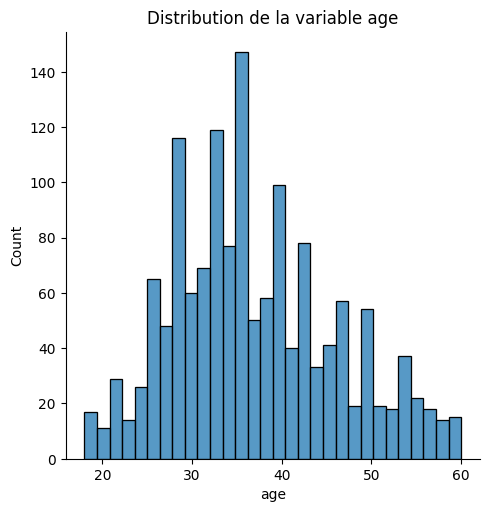

---------- Analyse de la variable : genre ----------
Type de la variable : object
Nombre de valeurs uniques : 2
Valeurs uniques : ['F' 'M']
Statistiques descriptives :
count     1470
unique       2
top          M
freq       882
Name: genre, dtype: object
Distribution des valeurs :


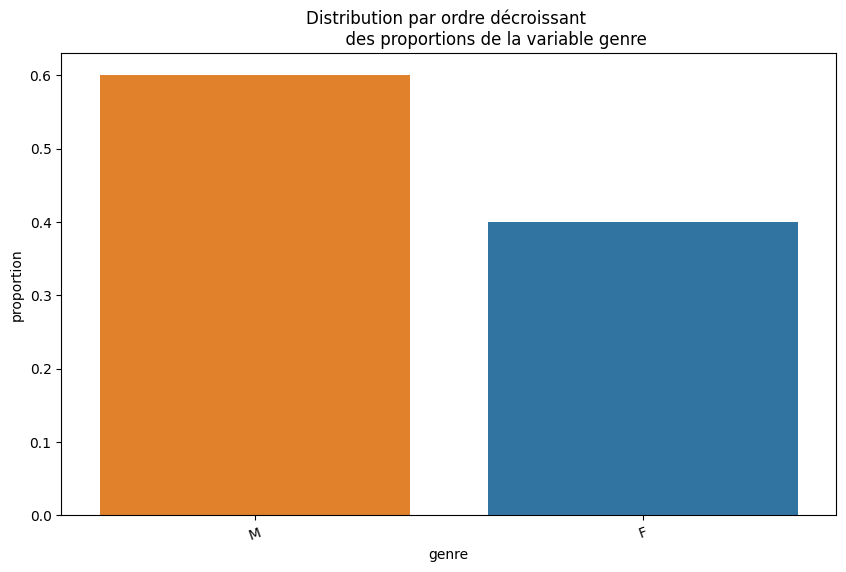

---------- Analyse de la variable : revenu_mensuel ----------
Type de la variable : int64
Nombre de valeurs uniques : 1349
Valeurs uniques : [5993 5130 2090 ... 9991 5390 4404]
Statistiques descriptives :
count     1470.000000
mean      6502.931293
std       4707.956783
min       1009.000000
25%       2911.000000
50%       4919.000000
75%       8379.000000
max      19999.000000
Name: revenu_mensuel, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

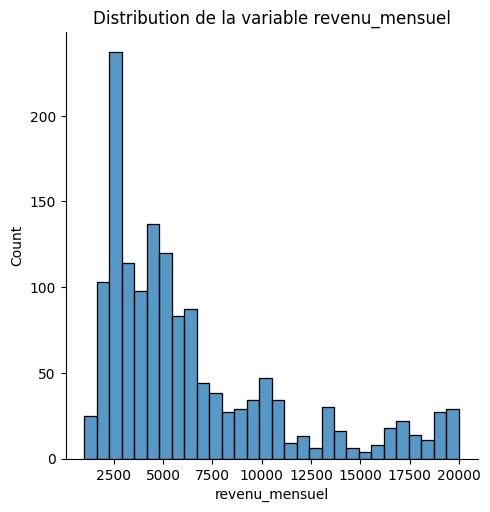

---------- Analyse de la variable : statut_marital ----------
Type de la variable : object
Nombre de valeurs uniques : 3
Valeurs uniques : ['Célibataire' 'Marié(e)' 'Divorcé(e)']
Statistiques descriptives :
count         1470
unique           3
top       Marié(e)
freq           673
Name: statut_marital, dtype: object
Distribution des valeurs :


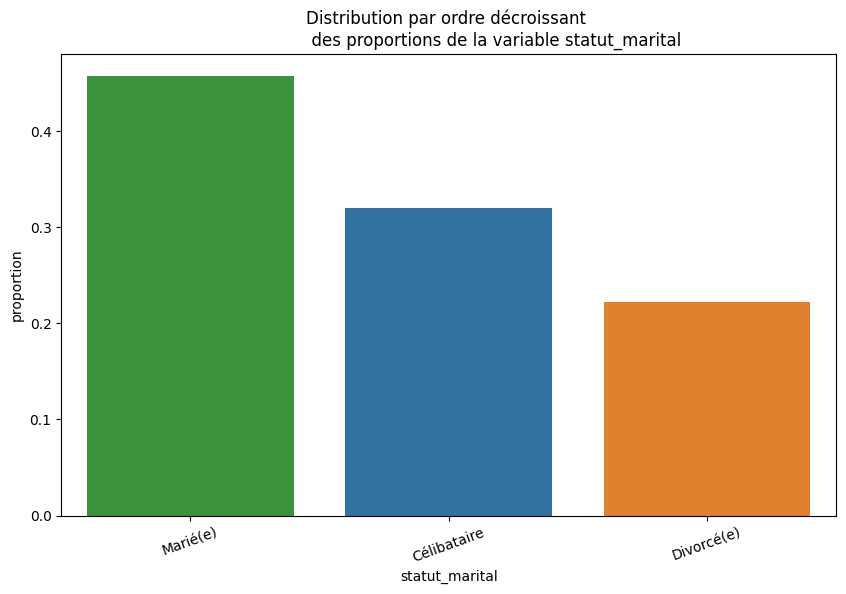

---------- Analyse de la variable : departement ----------
Type de la variable : object
Nombre de valeurs uniques : 3
Valeurs uniques : ['Commercial' 'Consulting' 'Ressources Humaines']
Statistiques descriptives :
count           1470
unique             3
top       Consulting
freq             961
Name: departement, dtype: object
Distribution des valeurs :


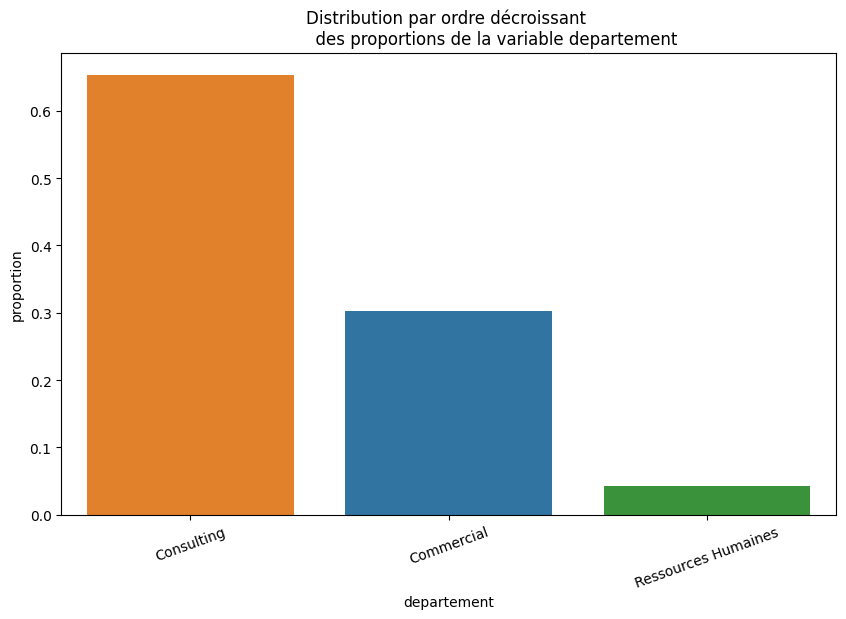

---------- Analyse de la variable : poste ----------
Type de la variable : object
Nombre de valeurs uniques : 9
Valeurs uniques : ['Cadre Commercial' 'Assistant de Direction' 'Consultant' 'Tech Lead'
 'Manager' 'Senior Manager' 'Représentant Commercial'
 'Directeur Technique' 'Ressources Humaines']
Statistiques descriptives :
count                 1470
unique                   9
top       Cadre Commercial
freq                   326
Name: poste, dtype: object
Distribution des valeurs :


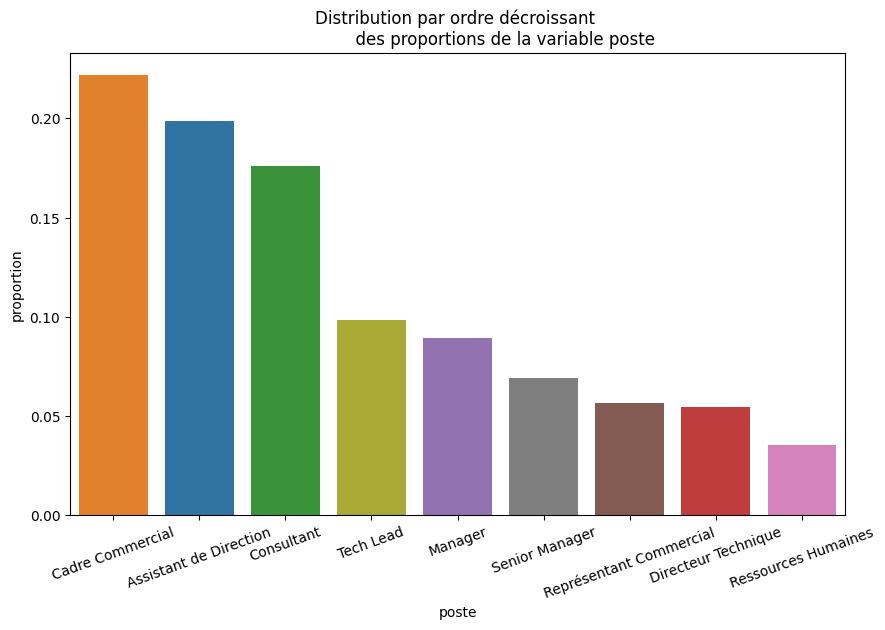

---------- Analyse de la variable : nombre_experiences_precedentes ----------
Type de la variable : int64
Nombre de valeurs uniques : 10
Valeurs uniques : [8 1 6 9 0 4 5 2 7 3]
Statistiques descriptives :
count    1470.000000
mean        2.693197
std         2.498009
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         9.000000
Name: nombre_experiences_precedentes, dtype: float64
Distribution des valeurs :


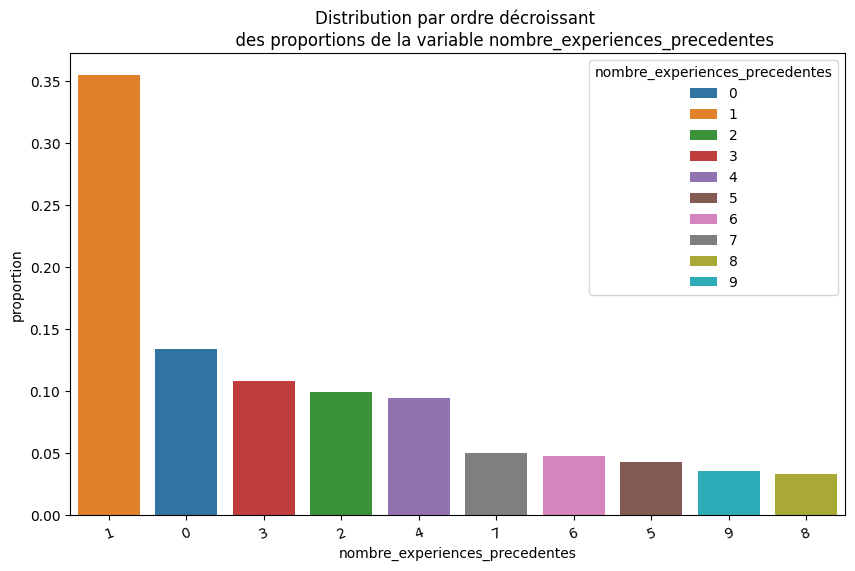

---------- Analyse de la variable : nombre_heures_travailless ----------
Type de la variable : int64
Nombre de valeurs uniques : 1
Valeurs uniques : [80]
Statistiques descriptives :
count    1470.0
mean       80.0
std         0.0
min        80.0
25%        80.0
50%        80.0
75%        80.0
max        80.0
Name: nombre_heures_travailless, dtype: float64
Distribution des valeurs :


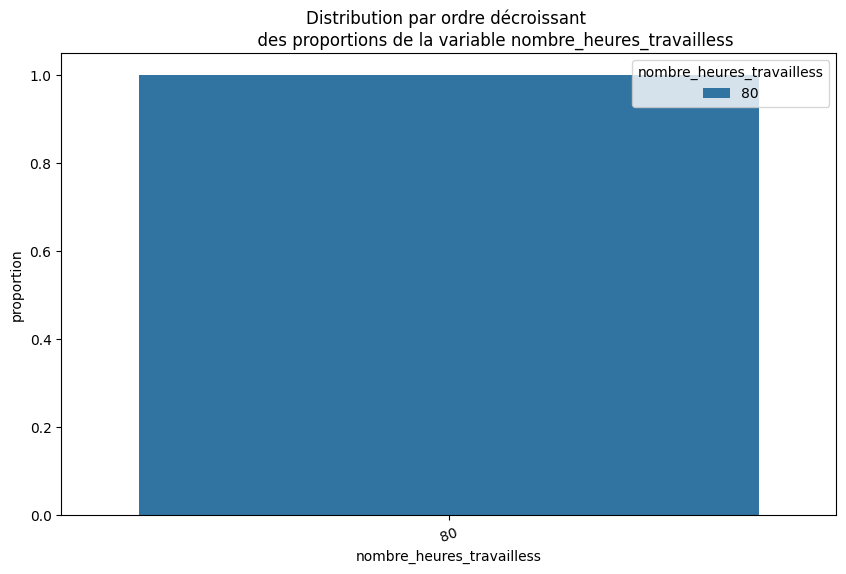

---------- Analyse de la variable : annee_experience_totale ----------
Type de la variable : int64
Nombre de valeurs uniques : 40
Valeurs uniques : [ 8 10  7  6 12  1 17  5  3 31 13  0 26 24 22  9 19  2 23 14 15  4 29 28
 21 25 20 11 16 37 38 30 40 18 36 34 32 33 35 27]
Statistiques descriptives :
count    1470.000000
mean       11.279592
std         7.780782
min         0.000000
25%         6.000000
50%        10.000000
75%        15.000000
max        40.000000
Name: annee_experience_totale, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

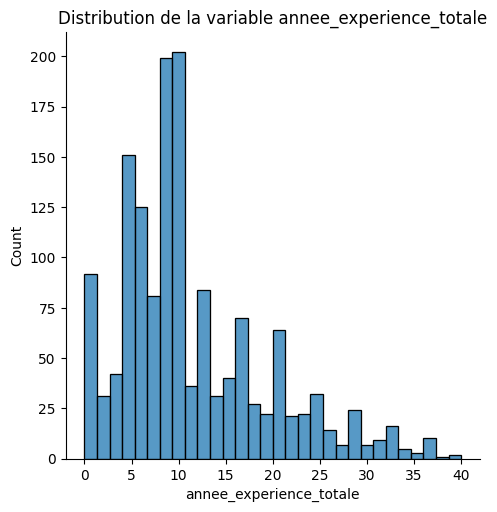

---------- Analyse de la variable : annees_dans_l_entreprise ----------
Type de la variable : int64
Nombre de valeurs uniques : 37
Valeurs uniques : [ 6 10  0  8  2  7  1  9  5  4 25  3 12 14 22 15 27 21 17 11 13 37 16 20
 40 24 33 19 36 18 29 31 32 34 26 30 23]
Statistiques descriptives :
count    1470.000000
mean        7.008163
std         6.126525
min         0.000000
25%         3.000000
50%         5.000000
75%         9.000000
max        40.000000
Name: annees_dans_l_entreprise, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

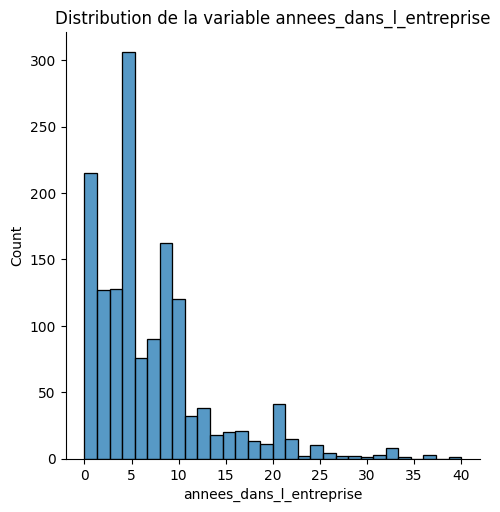

---------- Analyse de la variable : annees_dans_le_poste_actuel ----------
Type de la variable : int64
Nombre de valeurs uniques : 19
Valeurs uniques : [ 4  7  0  2  5  9  8  3  6 13  1 15 14 16 11 10 12 18 17]
Statistiques descriptives :
count    1470.000000
mean        4.229252
std         3.623137
min         0.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        18.000000
Name: annees_dans_le_poste_actuel, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

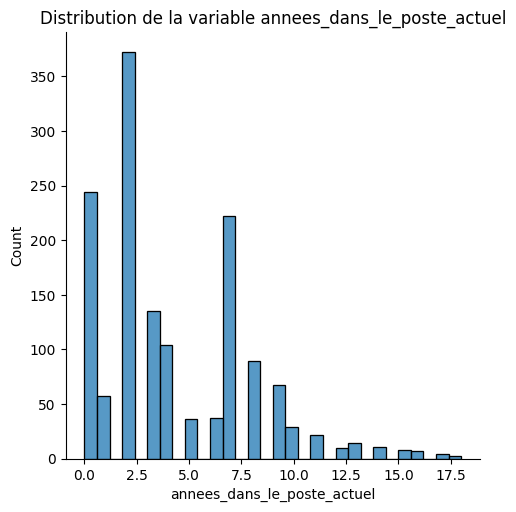

---------- Analyse de la variable : satisfaction_employee_environnement ----------
Type de la variable : int64
Nombre de valeurs uniques : 4
Valeurs uniques : [2 3 4 1]
Statistiques descriptives :
count    1470.000000
mean        2.721769
std         1.093082
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: satisfaction_employee_environnement, dtype: float64
Distribution des valeurs :


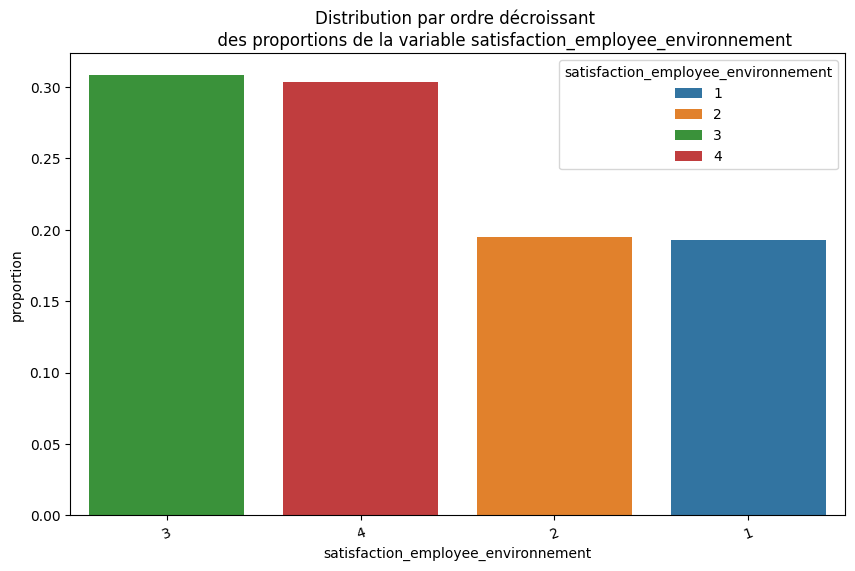

---------- Analyse de la variable : note_evaluation_precedente ----------
Type de la variable : int64
Nombre de valeurs uniques : 4
Valeurs uniques : [3 2 4 1]
Statistiques descriptives :
count    1470.000000
mean        2.729932
std         0.711561
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: note_evaluation_precedente, dtype: float64
Distribution des valeurs :


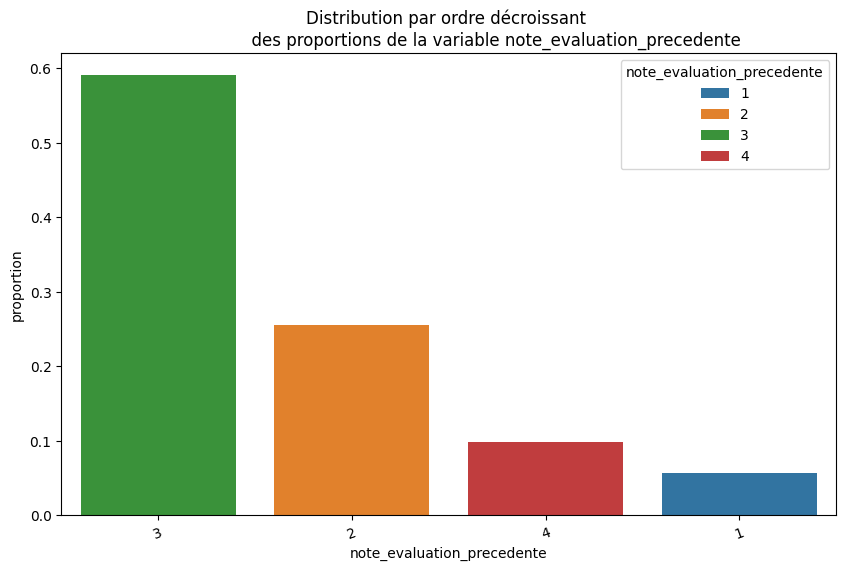

---------- Analyse de la variable : niveau_hierarchique_poste ----------
Type de la variable : int64
Nombre de valeurs uniques : 5
Valeurs uniques : [2 1 3 4 5]
Statistiques descriptives :
count    1470.000000
mean        2.063946
std         1.106940
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: niveau_hierarchique_poste, dtype: float64
Distribution des valeurs :


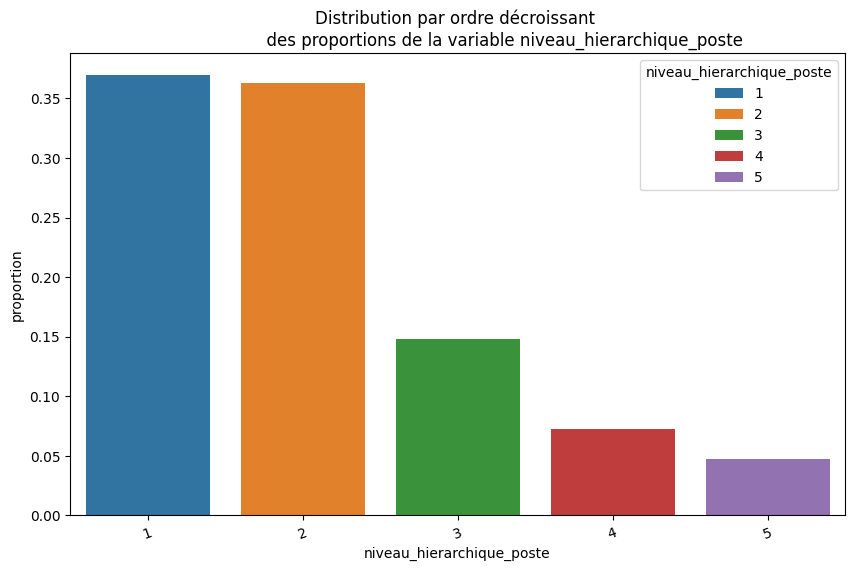

---------- Analyse de la variable : satisfaction_employee_nature_travail ----------
Type de la variable : int64
Nombre de valeurs uniques : 4
Valeurs uniques : [4 2 3 1]
Statistiques descriptives :
count    1470.000000
mean        2.728571
std         1.102846
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: satisfaction_employee_nature_travail, dtype: float64
Distribution des valeurs :


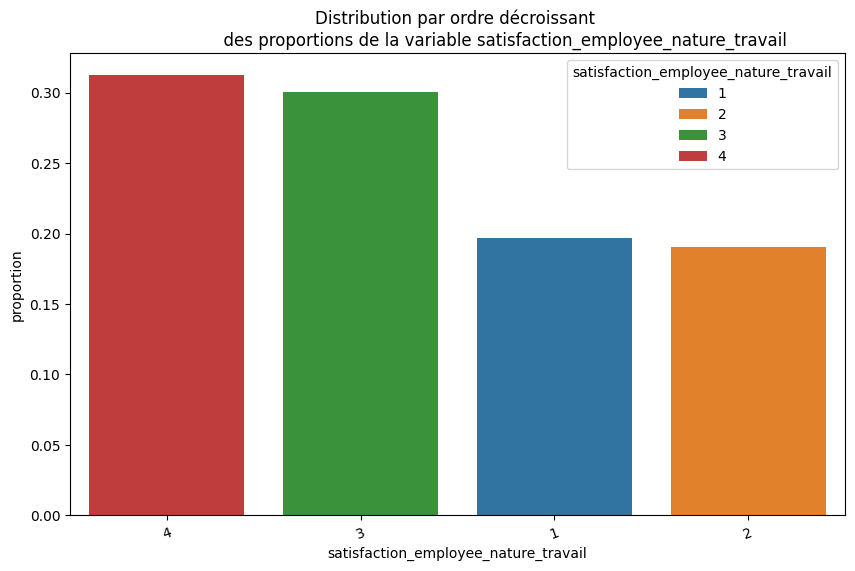

---------- Analyse de la variable : satisfaction_employee_equipe ----------
Type de la variable : int64
Nombre de valeurs uniques : 4
Valeurs uniques : [1 4 2 3]
Statistiques descriptives :
count    1470.000000
mean        2.712245
std         1.081209
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: satisfaction_employee_equipe, dtype: float64
Distribution des valeurs :


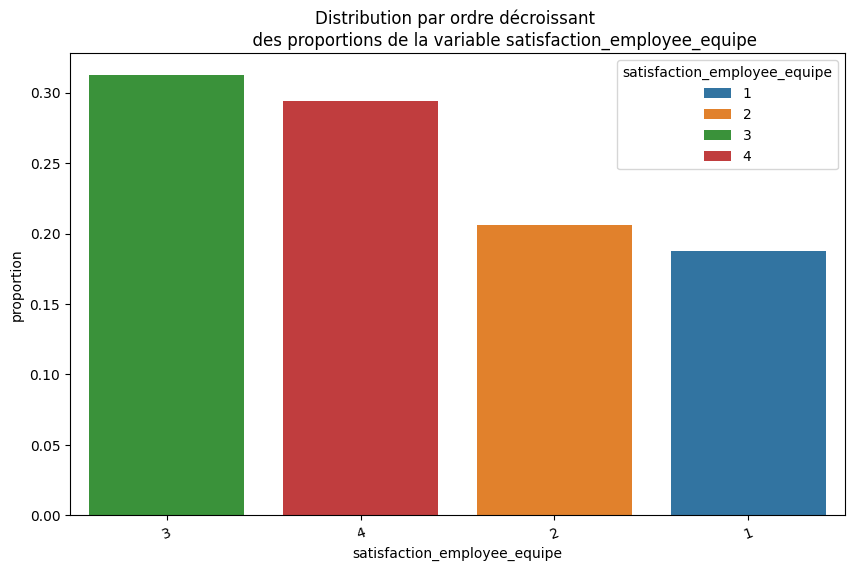

---------- Analyse de la variable : satisfaction_employee_equilibre_pro_perso ----------
Type de la variable : int64
Nombre de valeurs uniques : 4
Valeurs uniques : [1 3 2 4]
Statistiques descriptives :
count    1470.000000
mean        2.761224
std         0.706476
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: satisfaction_employee_equilibre_pro_perso, dtype: float64
Distribution des valeurs :


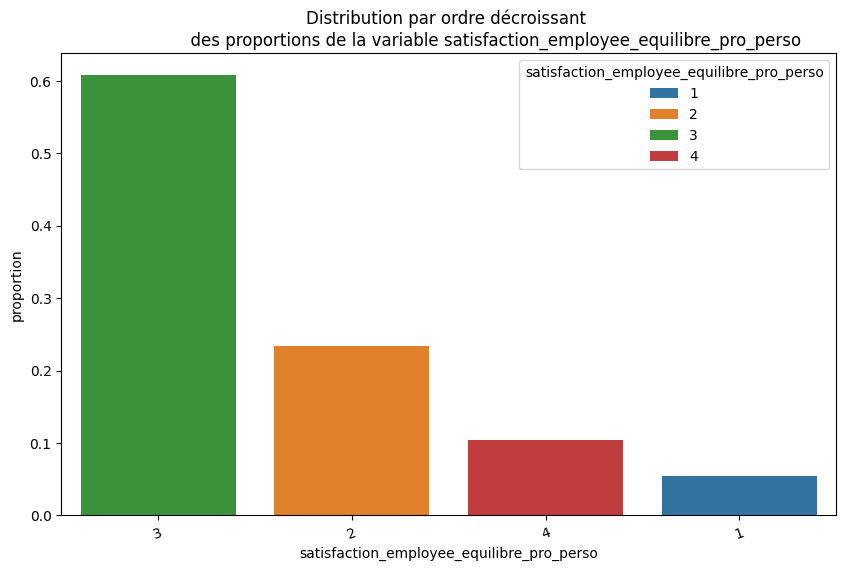

---------- Analyse de la variable : note_evaluation_actuelle ----------
Type de la variable : int64
Nombre de valeurs uniques : 2
Valeurs uniques : [3 4]
Statistiques descriptives :
count    1470.000000
mean        3.153741
std         0.360824
min         3.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: note_evaluation_actuelle, dtype: float64
Distribution des valeurs :


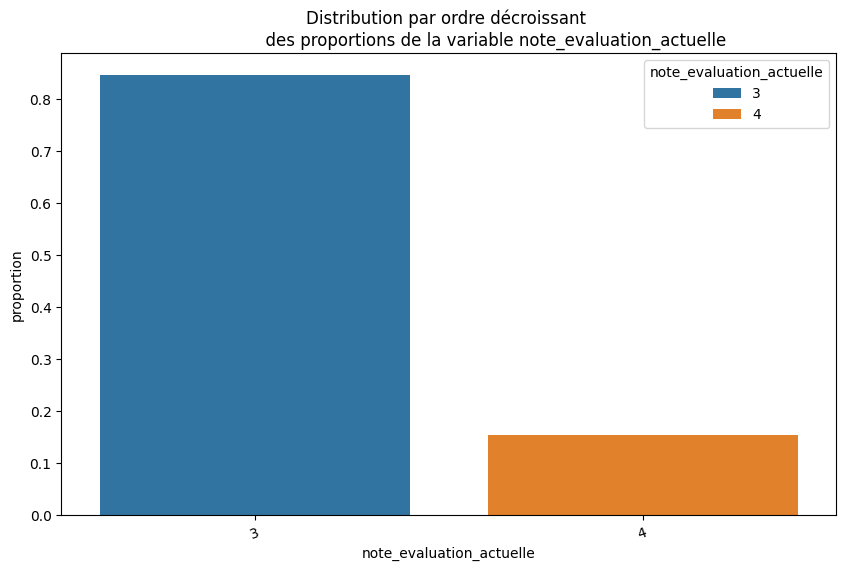

---------- Analyse de la variable : heure_supplementaires ----------
Type de la variable : object
Nombre de valeurs uniques : 2
Valeurs uniques : ['Oui' 'Non']
Statistiques descriptives :
count     1470
unique       2
top        Non
freq      1054
Name: heure_supplementaires, dtype: object
Distribution des valeurs :


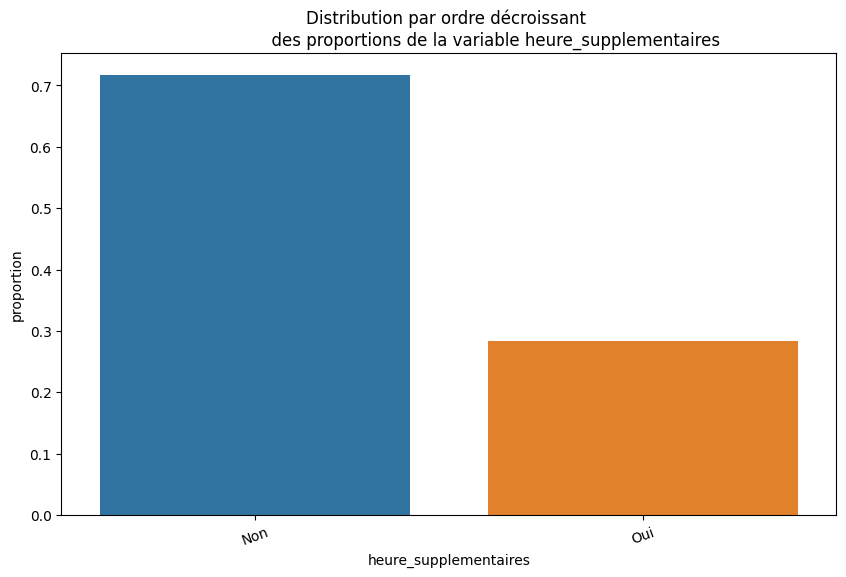

---------- Analyse de la variable : augementation_salaire_precedente ----------
Type de la variable : object
Nombre de valeurs uniques : 15
Valeurs uniques : ['11 %' '23 %' '15 %' '12 %' '13 %' '20 %' '22 %' '21 %' '17 %' '14 %'
 '16 %' '18 %' '19 %' '24 %' '25 %']
Statistiques descriptives :
count     1470
unique      15
top       11 %
freq       210
Name: augementation_salaire_precedente, dtype: object
Distribution des valeurs :


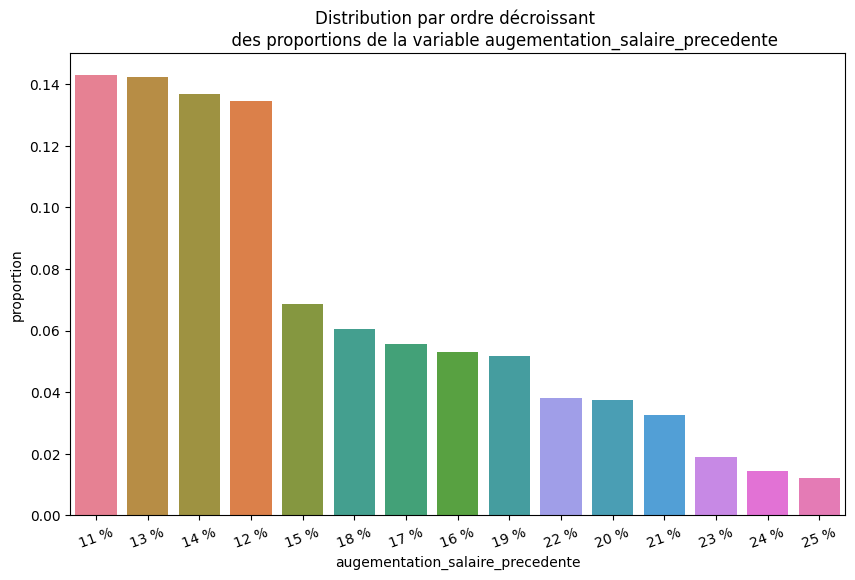

---------- Analyse de la variable : a_quitte_l_entreprise ----------
Type de la variable : object
Nombre de valeurs uniques : 2
Valeurs uniques : ['Oui' 'Non']
Statistiques descriptives :
count     1470
unique       2
top        Non
freq      1233
Name: a_quitte_l_entreprise, dtype: object
Distribution des valeurs :


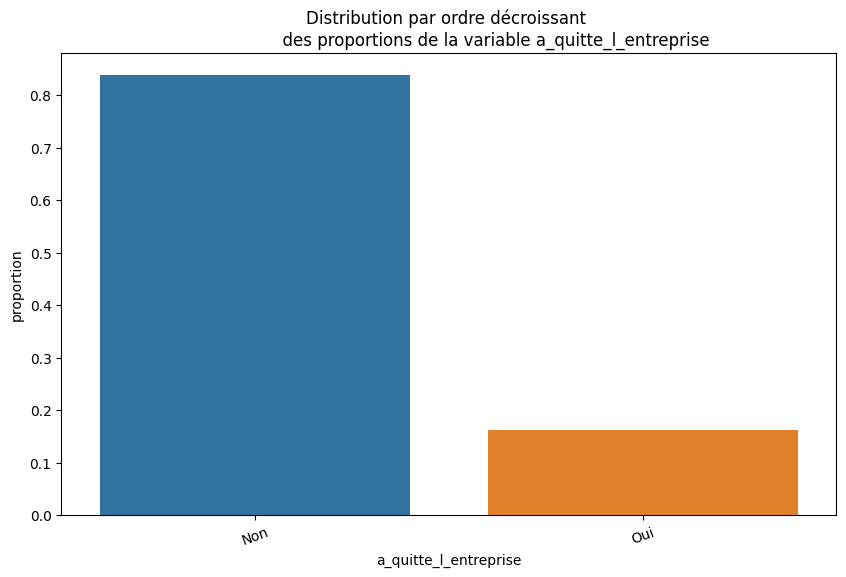

---------- Analyse de la variable : nombre_participation_pee ----------
Type de la variable : int64
Nombre de valeurs uniques : 4
Valeurs uniques : [0 1 3 2]
Statistiques descriptives :
count    1470.000000
mean        0.793878
std         0.852077
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: nombre_participation_pee, dtype: float64
Distribution des valeurs :


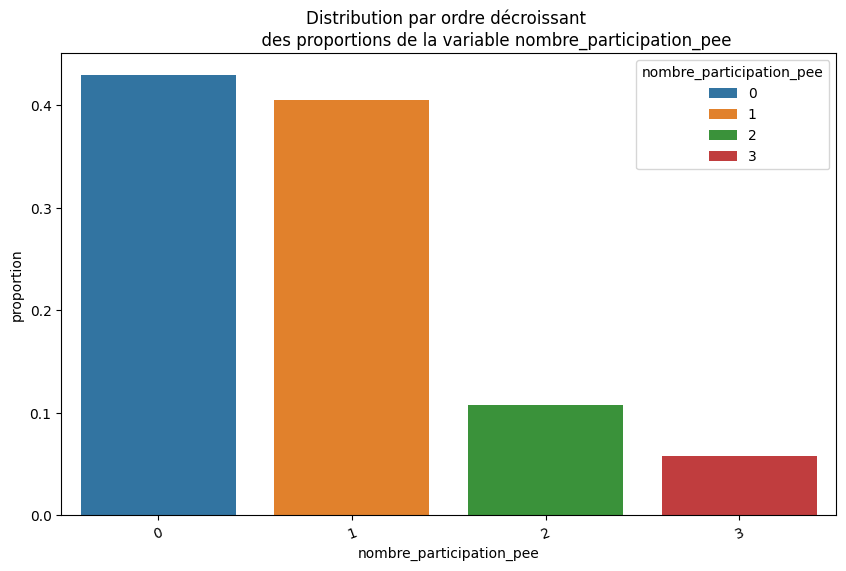

---------- Analyse de la variable : nb_formations_suivies ----------
Type de la variable : int64
Nombre de valeurs uniques : 7
Valeurs uniques : [0 3 2 5 1 4 6]
Statistiques descriptives :
count    1470.000000
mean        2.799320
std         1.289271
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         6.000000
Name: nb_formations_suivies, dtype: float64
Distribution des valeurs :


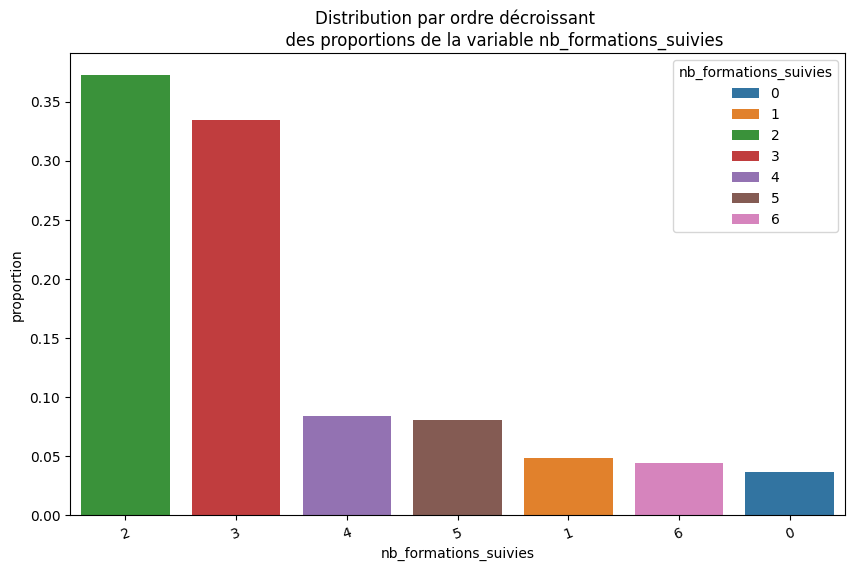

---------- Analyse de la variable : nombre_employee_sous_responsabilite ----------
Type de la variable : int64
Nombre de valeurs uniques : 1
Valeurs uniques : [1]
Statistiques descriptives :
count    1470.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: nombre_employee_sous_responsabilite, dtype: float64
Distribution des valeurs :


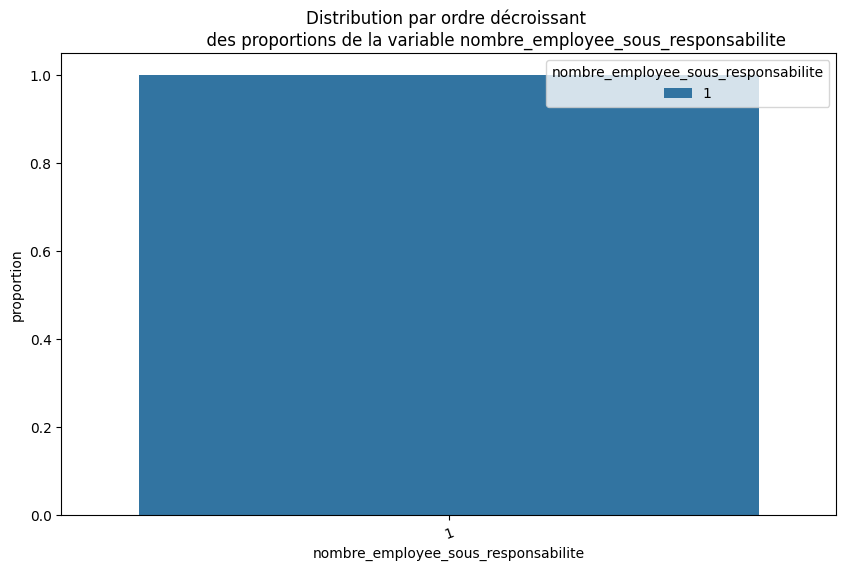

---------- Analyse de la variable : distance_domicile_travail ----------
Type de la variable : int64
Nombre de valeurs uniques : 29
Valeurs uniques : [ 1  8  2  3 24 23 27 16 15 26 19 21  5 11  9  7  6 10  4 25 12 18 29 22
 14 20 28 17 13]
Statistiques descriptives :
count    1470.000000
mean        9.192517
std         8.106864
min         1.000000
25%         2.000000
50%         7.000000
75%        14.000000
max        29.000000
Name: distance_domicile_travail, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

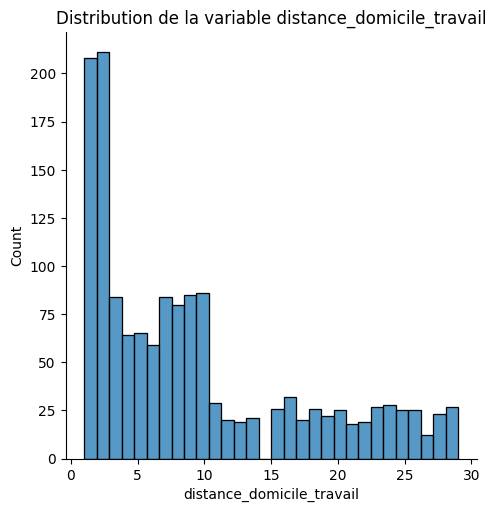

---------- Analyse de la variable : niveau_education ----------
Type de la variable : int64
Nombre de valeurs uniques : 5
Valeurs uniques : [2 1 4 3 5]
Statistiques descriptives :
count    1470.000000
mean        2.912925
std         1.024165
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: niveau_education, dtype: float64
Distribution des valeurs :


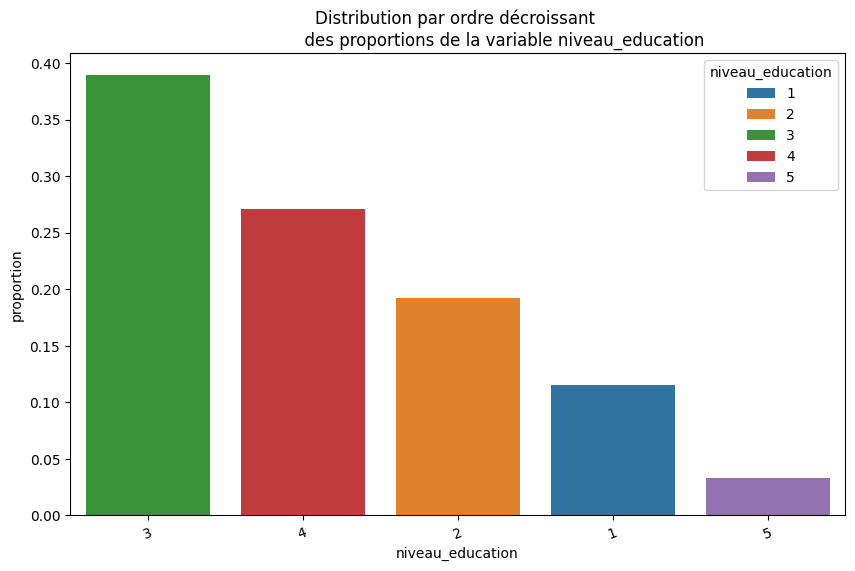

---------- Analyse de la variable : domaine_etude ----------
Type de la variable : object
Nombre de valeurs uniques : 6
Valeurs uniques : ['Infra & Cloud' 'Autre' 'Transformation Digitale' 'Marketing'
 'Entrepreunariat' 'Ressources Humaines']
Statistiques descriptives :
count              1470
unique                6
top       Infra & Cloud
freq                606
Name: domaine_etude, dtype: object
Distribution des valeurs :


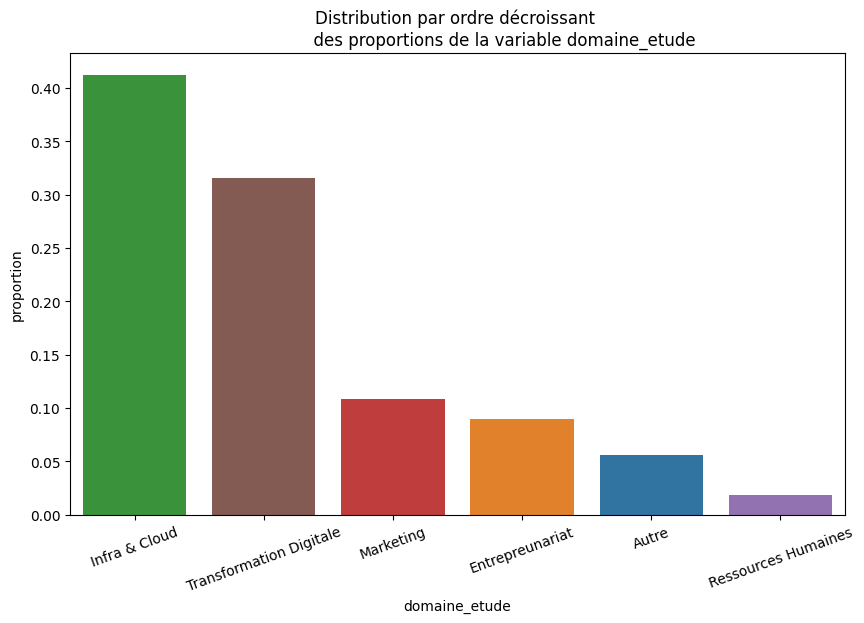

---------- Analyse de la variable : ayant_enfants ----------
Type de la variable : object
Nombre de valeurs uniques : 1
Valeurs uniques : ['Y']
Statistiques descriptives :
count     1470
unique       1
top          Y
freq      1470
Name: ayant_enfants, dtype: object
Distribution des valeurs :


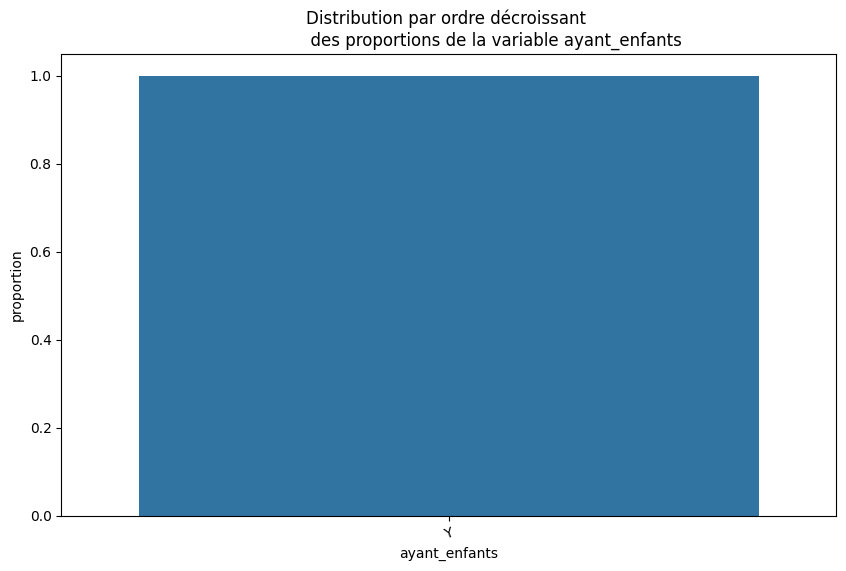

---------- Analyse de la variable : frequence_deplacement ----------
Type de la variable : object
Nombre de valeurs uniques : 3
Valeurs uniques : ['Occasionnel' 'Frequent' 'Aucun']
Statistiques descriptives :
count            1470
unique              3
top       Occasionnel
freq             1043
Name: frequence_deplacement, dtype: object
Distribution des valeurs :


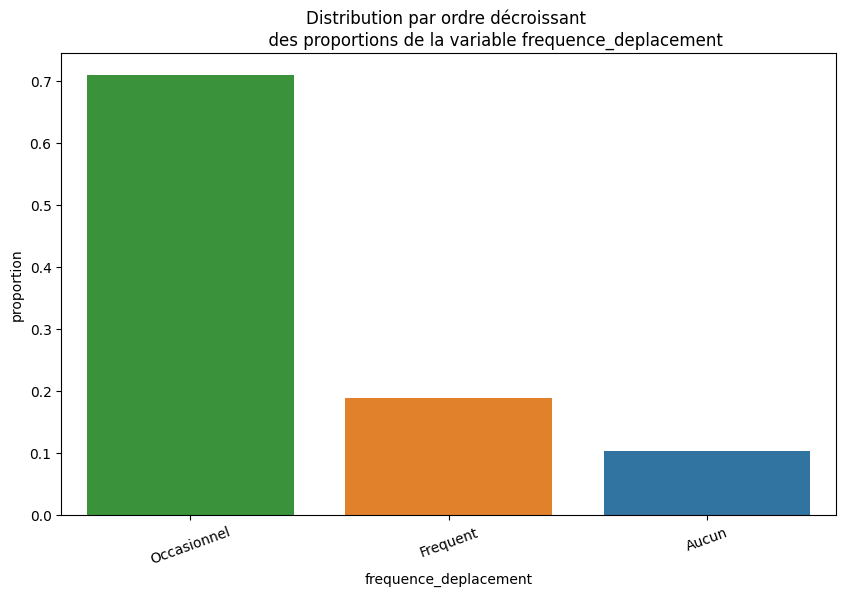

---------- Analyse de la variable : annees_depuis_la_derniere_promotion ----------
Type de la variable : int64
Nombre de valeurs uniques : 16
Valeurs uniques : [ 0  1  3  2  7  4  8  6  5 15  9 13 12 10 11 14]
Statistiques descriptives :
count    1470.000000
mean        2.187755
std         3.222430
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        15.000000
Name: annees_depuis_la_derniere_promotion, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

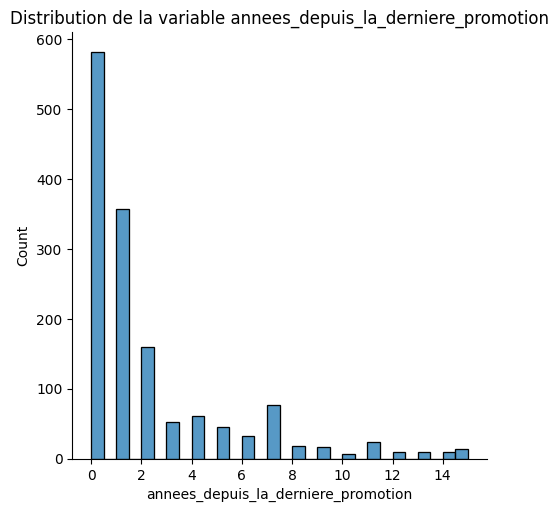

---------- Analyse de la variable : annes_sous_responsable_actuel ----------
Type de la variable : int64
Nombre de valeurs uniques : 18
Valeurs uniques : [ 5  7  0  2  6  8  3 11 17  1  4 12  9 10 15 13 16 14]
Statistiques descriptives :
count    1470.000000
mean        4.123129
std         3.568136
min         0.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        17.000000
Name: annes_sous_responsable_actuel, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

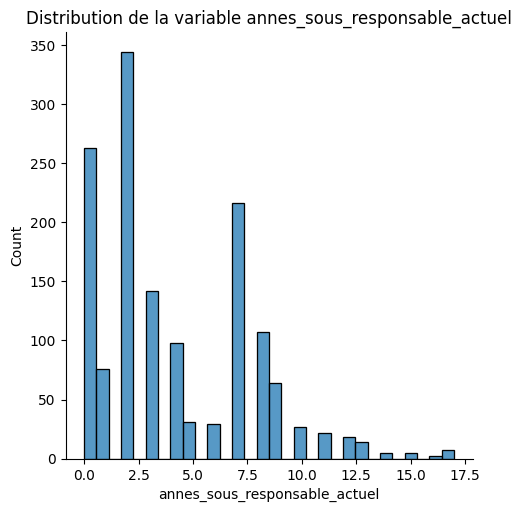

In [9]:
# EDA table df_master    
EDA_de_table(df=df_master ,df_name="df_master",rotation=20)

In [10]:
df_master.select_dtypes(include="object").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   genre                             1470 non-null   object
 1   statut_marital                    1470 non-null   object
 2   departement                       1470 non-null   object
 3   poste                             1470 non-null   object
 4   heure_supplementaires             1470 non-null   object
 5   augementation_salaire_precedente  1470 non-null   object
 6   a_quitte_l_entreprise             1470 non-null   object
 7   domaine_etude                     1470 non-null   object
 8   ayant_enfants                     1470 non-null   object
 9   frequence_deplacement             1470 non-null   object
dtypes: object(10)
memory usage: 115.0+ KB


Changeons les variables catégorielles du type 'objet' à 'category'.   

In [11]:
# transformation de certaines colonnes en type catégoriel
for col in df_master.select_dtypes(include='object').columns:
        df_master[col] = df_master[col].astype('category')
        

# verification des types changés 
#df_master .info()

In [12]:
# on retire les variables sans variabilité
no_var_col = ['ayant_enfants','nombre_heures_travailless','nombre_employee_sous_responsabilite']
df_master .drop(no_var_col,axis=1,inplace=True)

In [13]:
# get features 
numerical_features = df_master .select_dtypes(include="number").columns.tolist()
categorical_features = df_master .select_dtypes(include="category").columns.tolist()

Certaines variables avec les prefixes "satisfaction" ou "niveau" nous semblent plus être des variables qualitatives que quantitatives.  
Nous allons changer leur type en quantitative.   

In [14]:
# aperçu des vraiables à changer en catégorielle
vars_a_caster = [col for col in df_master .columns if ('satis' in col.lower() or 'nivea' in col.lower())]
df_master [vars_a_caster].head()

,satisfaction_employee_environnement,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,niveau_education
0,2,2,4,1,1,2
1,3,2,2,4,3,1
2,4,1,3,2,3,2
3,4,1,3,3,3,4
4,1,1,2,4,3,1


In [15]:
# ajouter aux categorical_features les colonnes contenant 'satis' ou 'nivea' (insensible à la casse)
matches = [col for col in df_master .columns if ('satis' in col.lower() or 'nivea' in col.lower())]

# éviter les doublons et les ajouter
for m in matches:
    if m not in categorical_features:
        df_master [m] = df_master [m].astype('category')
    



In [16]:
# vérifier le changement 
#df_master .info()

In [17]:
df_master .describe(include = 'category').T

,count,unique,top,freq
genre,1470,2,M,882
statut_marital,1470,3,Marié(e),673
departement,1470,3,Consulting,961
poste,1470,9,Cadre Commercial,326
satisfaction_employee_environnement,1470,4,3,453
niveau_hierarchique_poste,1470,5,1,543
satisfaction_employee_nature_travail,1470,4,4,459
satisfaction_employee_equipe,1470,4,3,459
satisfaction_employee_equilibre_pro_perso,1470,4,3,893
heure_supplementaires,1470,2,Non,1054


In [18]:
# changer le type de la variable "augementation_salaire_precedente" en numérique et renommer la variable en "augmentation_salaire_precedente_pourc"
df_master ['augementation_salaire_precedente'] = [int(x.split(' ')[0]) for x in df_master ['augementation_salaire_precedente']]
df_master .rename(columns = {"augementation_salaire_precedente":"augmentation_salaire_precedente_pourc"},inplace=True)

In [19]:
# aperçu variables numériques 
df_master .describe(include ="number").T

,count,mean,std,min,25%,50%,75%,max
age,1470.0,36.923810,9.135373,18.0,30.0,36.0,43.0,60.0
revenu_mensuel,1470.0,6502.931293,4707.956783,1009.0,2911.0,4919.0,8379.0,19999.0
nombre_experiences_precedentes,1470.0,2.693197,2.498009,0.0,1.0,2.0,4.0,9.0
annee_experience_totale,1470.0,11.279592,7.780782,0.0,6.0,10.0,15.0,40.0
annees_dans_l_entreprise,1470.0,7.008163,6.126525,0.0,3.0,5.0,9.0,40.0
annees_dans_le_poste_actuel,1470.0,4.229252,3.623137,0.0,2.0,3.0,7.0,18.0
note_evaluation_precedente,1470.0,2.729932,0.711561,1.0,2.0,3.0,3.0,4.0
note_evaluation_actuelle,1470.0,3.153741,0.360824,3.0,3.0,3.0,3.0,4.0
augmentation_salaire_precedente_pourc,1470.0,15.209524,3.659938,11.0,12.0,14.0,18.0,25.0
nombre_participation_pee,1470.0,0.793878,0.852077,0.0,0.0,1.0,1.0,3.0


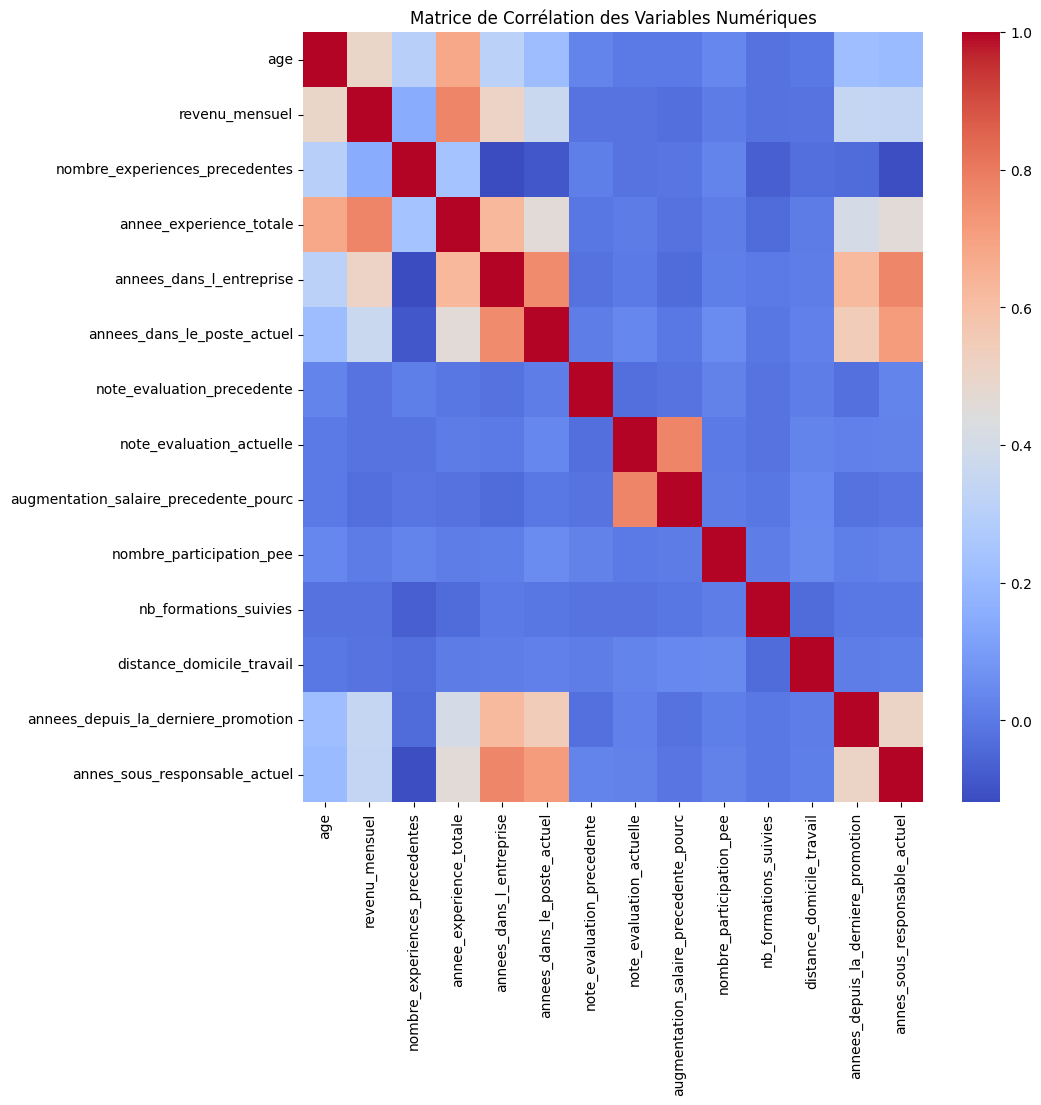

In [20]:
# recherche de correlations 
data_numeric = df_master .select_dtypes(include='number')
corr_matrix = data_numeric.corr()

# plot corr_mat
plt.figure(figsize=[10,10])
sns.heatmap(corr_matrix,annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Corrélation des Variables Numériques')
plt.show()

In [21]:
# filtrer les variables correlées 
# Définir le seuil de corrélation
THRESHOLD = 0.90
# Créer un ensemble (set) pour stocker les noms de colonnes à supprimer
cols_to_drop = set()

# Parcourir la matrice de corrélation
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        # Vérifier si la corrélation est supérieure au seuil
        if corr_matrix.iloc[i, j] > THRESHOLD:
            colname = corr_matrix.columns[i] # Nom de la colonne à l'index 'i'
            cols_to_drop.add(colname)
            
# Supprimer les colonnes identifiées
df_filtered = df_master .drop(columns=cols_to_drop)

# Afficher les résultats
print("-" * 50)
print(f"Seuil de corrélation utilisé : {THRESHOLD}")
print(f"Nombre de variables initiales : {df_master .shape[1]}")
print(f"Nombre de variables supprimées : {len(cols_to_drop)}")
print(f"Variables supprimées : {list(cols_to_drop)}")
print(f"Nombre de variables restantes : {df_filtered.shape[1]}")
print("-" * 50)

--------------------------------------------------
Seuil de corrélation utilisé : 0.9
Nombre de variables initiales : 28
Nombre de variables supprimées : 0
Variables supprimées : []
Nombre de variables restantes : 28
--------------------------------------------------


Il n' y a pas de variables corrélées au seuil de correlation de : 0.9 

In [22]:
# sauvegarder df_master  en CSV (même dossier que les autres jeux de données)
output_path = '../Datasets/df_master.csv'
df_master .to_csv(output_path, index=False)
print(f"Fichier sauvegardé : {output_path} aux dimensions {df_master .shape} ")

Fichier sauvegardé : ../Datasets/df_master.csv aux dimensions (1470, 28) 


## construire un pîpeline pour normaliser les variables numériques et encoder les variables catégorielles en 

                ANALYSE DE LA TABLE : df_master                 
---------- Analyse de la variable : age ----------
Type de la variable : int64
Nombre de valeurs uniques : 43
Valeurs uniques : [41 49 37 33 27 32 59 30 38 36 35 29 31 34 28 22 53 24 21 42 44 46 39 43
 50 26 48 55 45 56 23 51 40 54 58 20 25 19 57 52 47 18 60]
Statistiques descriptives :
count    1470.000000
mean       36.923810
std         9.135373
min        18.000000
25%        30.000000
50%        36.000000
75%        43.000000
max        60.000000
Name: age, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

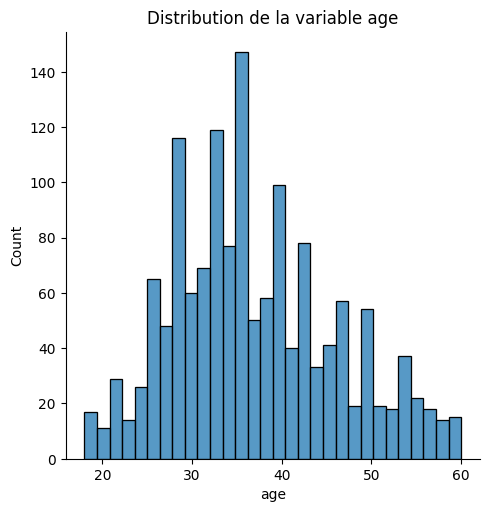

---------- Analyse de la variable : genre ----------
Type de la variable : category
Nombre de valeurs uniques : 2
Valeurs uniques : ['F', 'M']
Categories (2, object): ['F', 'M']
Statistiques descriptives :
count     1470
unique       2
top          M
freq       882
Name: genre, dtype: object
Distribution des valeurs :


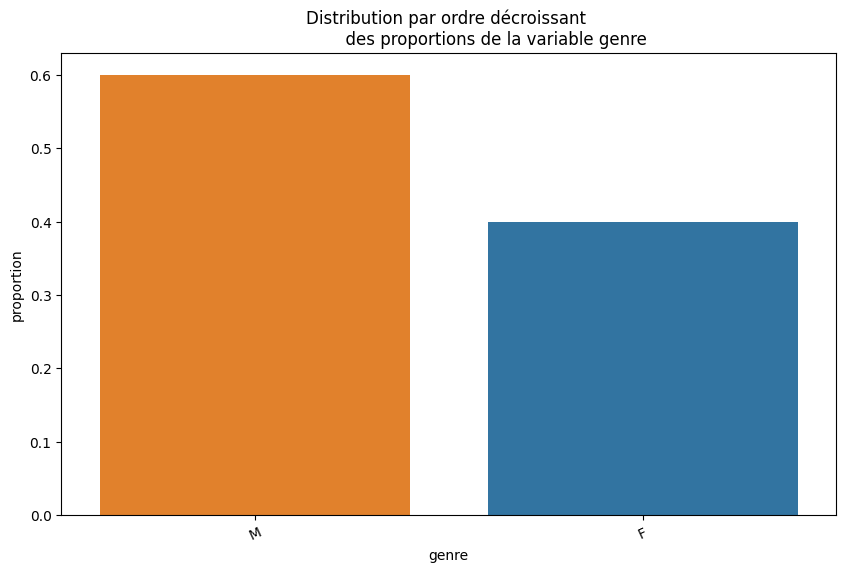

---------- Analyse de la variable : revenu_mensuel ----------
Type de la variable : int64
Nombre de valeurs uniques : 1349
Valeurs uniques : [5993 5130 2090 ... 9991 5390 4404]
Statistiques descriptives :
count     1470.000000
mean      6502.931293
std       4707.956783
min       1009.000000
25%       2911.000000
50%       4919.000000
75%       8379.000000
max      19999.000000
Name: revenu_mensuel, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

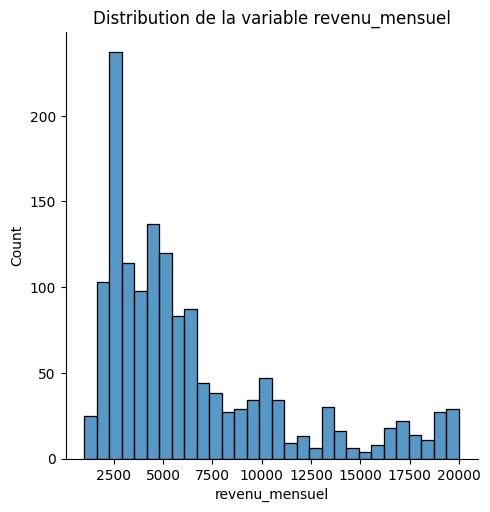

---------- Analyse de la variable : statut_marital ----------
Type de la variable : category
Nombre de valeurs uniques : 3
Valeurs uniques : ['Célibataire', 'Marié(e)', 'Divorcé(e)']
Categories (3, object): ['Célibataire', 'Divorcé(e)', 'Marié(e)']
Statistiques descriptives :
count         1470
unique           3
top       Marié(e)
freq           673
Name: statut_marital, dtype: object
Distribution des valeurs :


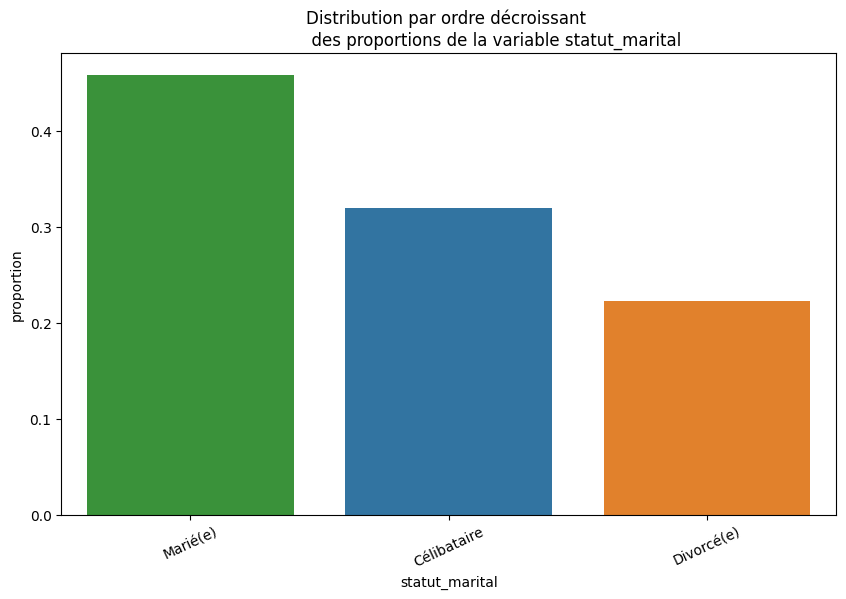

---------- Analyse de la variable : departement ----------
Type de la variable : category
Nombre de valeurs uniques : 3
Valeurs uniques : ['Commercial', 'Consulting', 'Ressources Humaines']
Categories (3, object): ['Commercial', 'Consulting', 'Ressources Humaines']
Statistiques descriptives :
count           1470
unique             3
top       Consulting
freq             961
Name: departement, dtype: object
Distribution des valeurs :


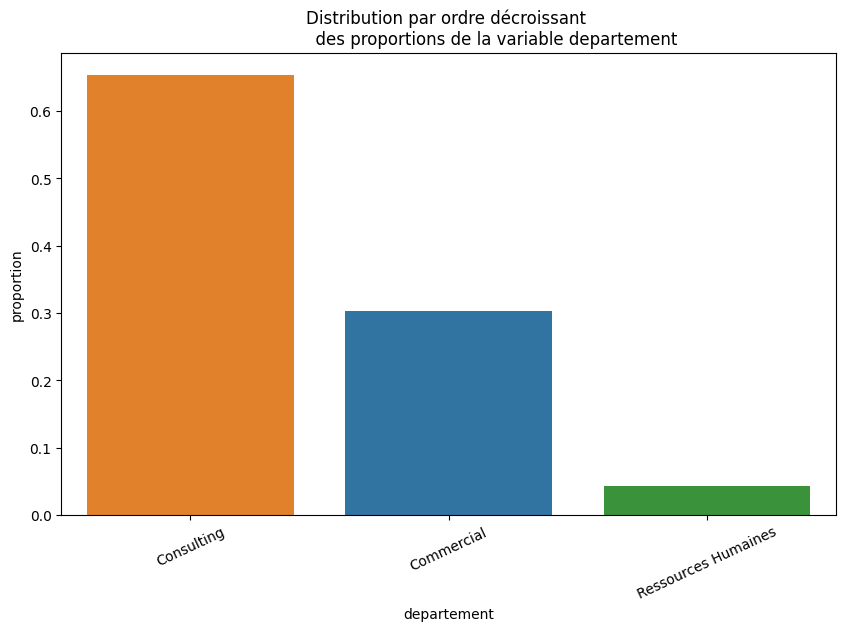

---------- Analyse de la variable : poste ----------
Type de la variable : category
Nombre de valeurs uniques : 9
Valeurs uniques : ['Cadre Commercial', 'Assistant de Direction', 'Consultant', 'Tech Lead', 'Manager', 'Senior Manager', 'Représentant Commercial', 'Directeur Technique', 'Ressources Humaines']
Categories (9, object): ['Assistant de Direction', 'Cadre Commercial', 'Consultant', 'Directeur Technique', ..., 'Représentant Commercial', 'Ressources Humaines', 'Senior Manager', 'Tech Lead']
Statistiques descriptives :
count                 1470
unique                   9
top       Cadre Commercial
freq                   326
Name: poste, dtype: object
Distribution des valeurs :


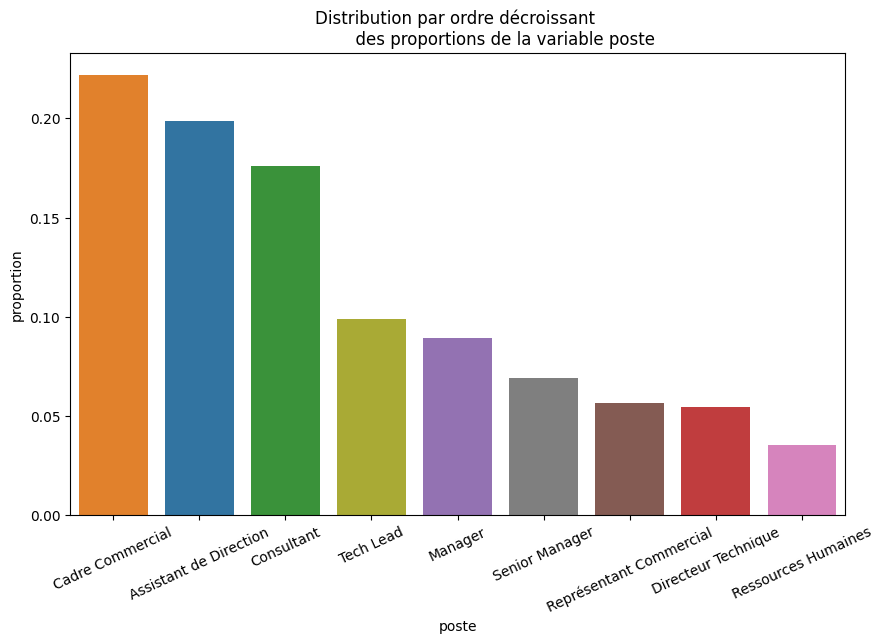

---------- Analyse de la variable : nombre_experiences_precedentes ----------
Type de la variable : int64
Nombre de valeurs uniques : 10
Valeurs uniques : [8 1 6 9 0 4 5 2 7 3]
Statistiques descriptives :
count    1470.000000
mean        2.693197
std         2.498009
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         9.000000
Name: nombre_experiences_precedentes, dtype: float64
Distribution des valeurs :


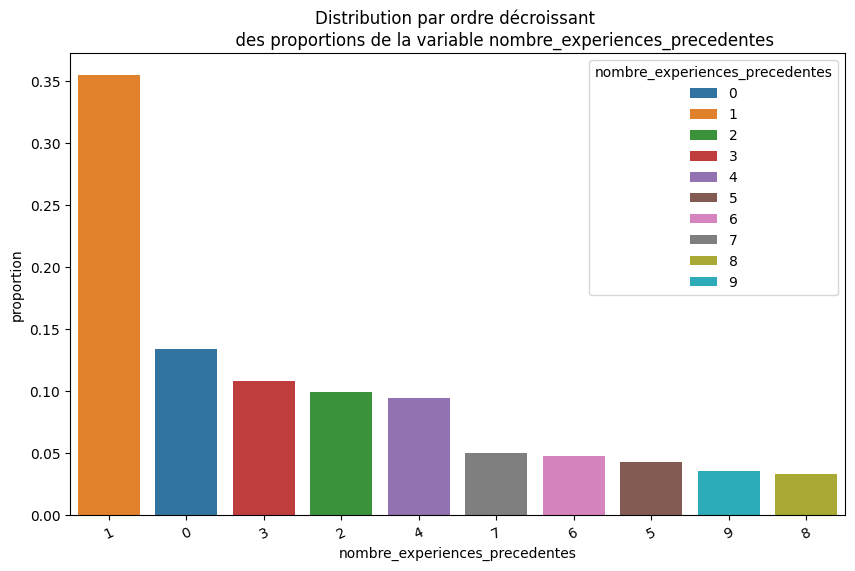

---------- Analyse de la variable : annee_experience_totale ----------
Type de la variable : int64
Nombre de valeurs uniques : 40
Valeurs uniques : [ 8 10  7  6 12  1 17  5  3 31 13  0 26 24 22  9 19  2 23 14 15  4 29 28
 21 25 20 11 16 37 38 30 40 18 36 34 32 33 35 27]
Statistiques descriptives :
count    1470.000000
mean       11.279592
std         7.780782
min         0.000000
25%         6.000000
50%        10.000000
75%        15.000000
max        40.000000
Name: annee_experience_totale, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

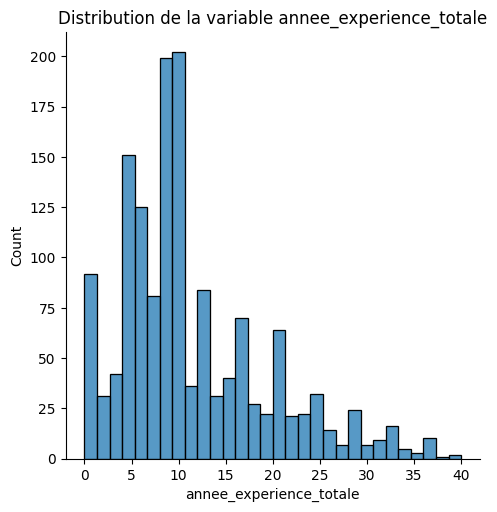

---------- Analyse de la variable : annees_dans_l_entreprise ----------
Type de la variable : int64
Nombre de valeurs uniques : 37
Valeurs uniques : [ 6 10  0  8  2  7  1  9  5  4 25  3 12 14 22 15 27 21 17 11 13 37 16 20
 40 24 33 19 36 18 29 31 32 34 26 30 23]
Statistiques descriptives :
count    1470.000000
mean        7.008163
std         6.126525
min         0.000000
25%         3.000000
50%         5.000000
75%         9.000000
max        40.000000
Name: annees_dans_l_entreprise, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

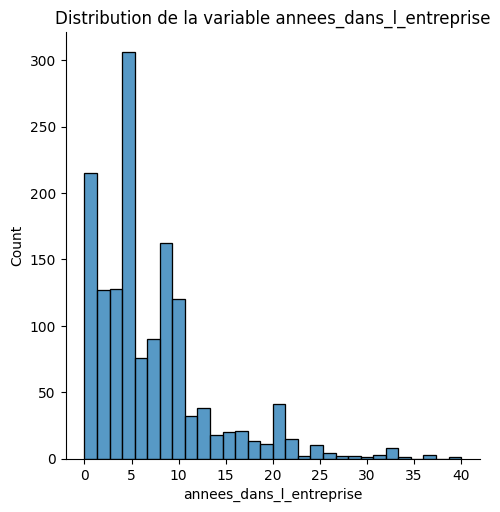

---------- Analyse de la variable : annees_dans_le_poste_actuel ----------
Type de la variable : int64
Nombre de valeurs uniques : 19
Valeurs uniques : [ 4  7  0  2  5  9  8  3  6 13  1 15 14 16 11 10 12 18 17]
Statistiques descriptives :
count    1470.000000
mean        4.229252
std         3.623137
min         0.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        18.000000
Name: annees_dans_le_poste_actuel, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

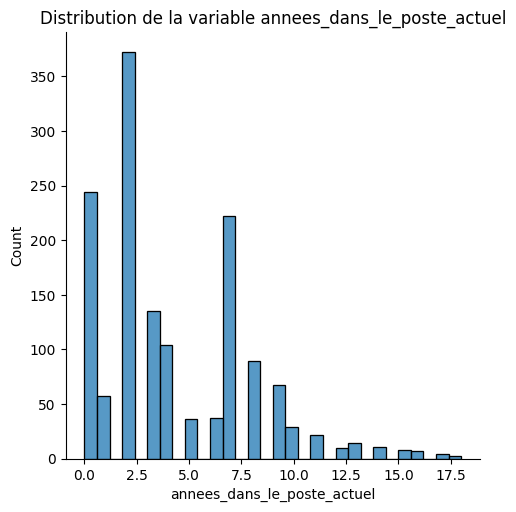

---------- Analyse de la variable : satisfaction_employee_environnement ----------
Type de la variable : category
Nombre de valeurs uniques : 4
Valeurs uniques : [2, 3, 4, 1]
Categories (4, int64): [1, 2, 3, 4]
Statistiques descriptives :
count     1470
unique       4
top          3
freq       453
Name: satisfaction_employee_environnement, dtype: int64
Distribution des valeurs :


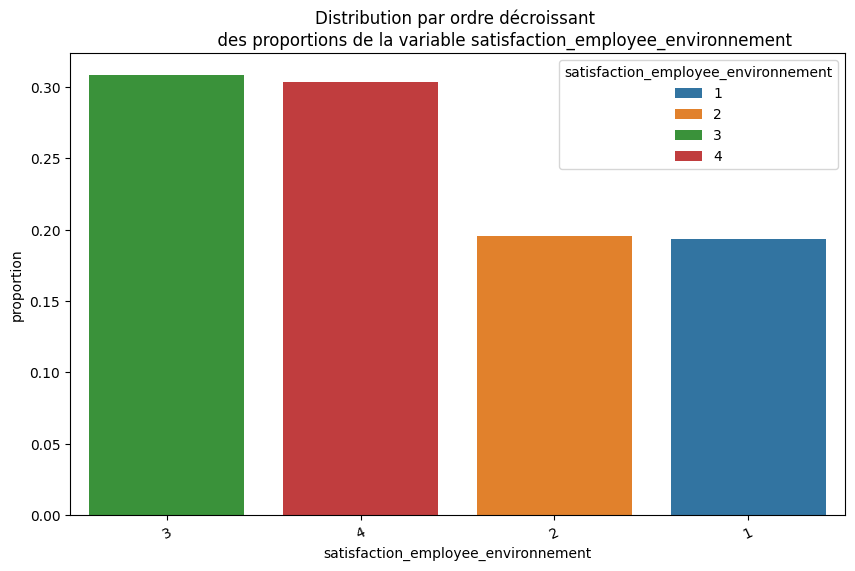

---------- Analyse de la variable : note_evaluation_precedente ----------
Type de la variable : int64
Nombre de valeurs uniques : 4
Valeurs uniques : [3 2 4 1]
Statistiques descriptives :
count    1470.000000
mean        2.729932
std         0.711561
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: note_evaluation_precedente, dtype: float64
Distribution des valeurs :


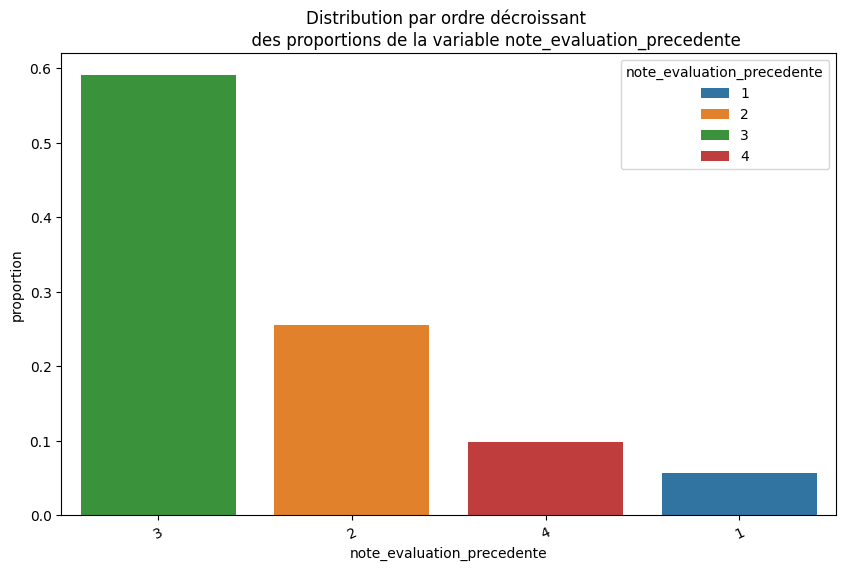

---------- Analyse de la variable : niveau_hierarchique_poste ----------
Type de la variable : category
Nombre de valeurs uniques : 5
Valeurs uniques : [2, 1, 3, 4, 5]
Categories (5, int64): [1, 2, 3, 4, 5]
Statistiques descriptives :
count     1470
unique       5
top          1
freq       543
Name: niveau_hierarchique_poste, dtype: int64
Distribution des valeurs :


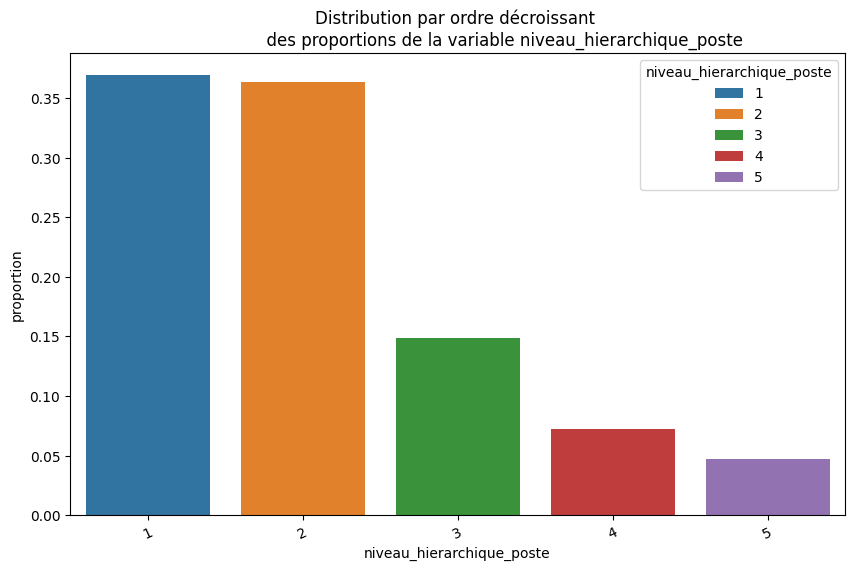

---------- Analyse de la variable : satisfaction_employee_nature_travail ----------
Type de la variable : category
Nombre de valeurs uniques : 4
Valeurs uniques : [4, 2, 3, 1]
Categories (4, int64): [1, 2, 3, 4]
Statistiques descriptives :
count     1470
unique       4
top          4
freq       459
Name: satisfaction_employee_nature_travail, dtype: int64
Distribution des valeurs :


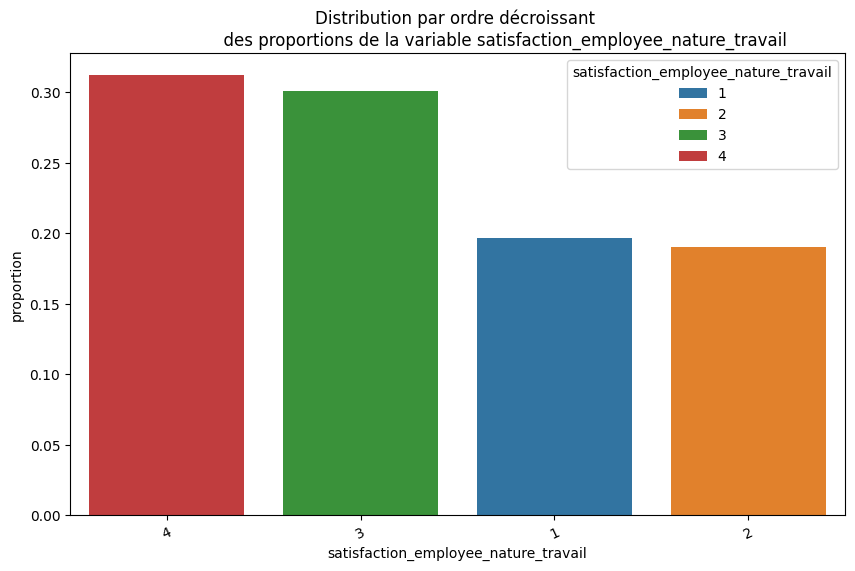

---------- Analyse de la variable : satisfaction_employee_equipe ----------
Type de la variable : category
Nombre de valeurs uniques : 4
Valeurs uniques : [1, 4, 2, 3]
Categories (4, int64): [1, 2, 3, 4]
Statistiques descriptives :
count     1470
unique       4
top          3
freq       459
Name: satisfaction_employee_equipe, dtype: int64
Distribution des valeurs :


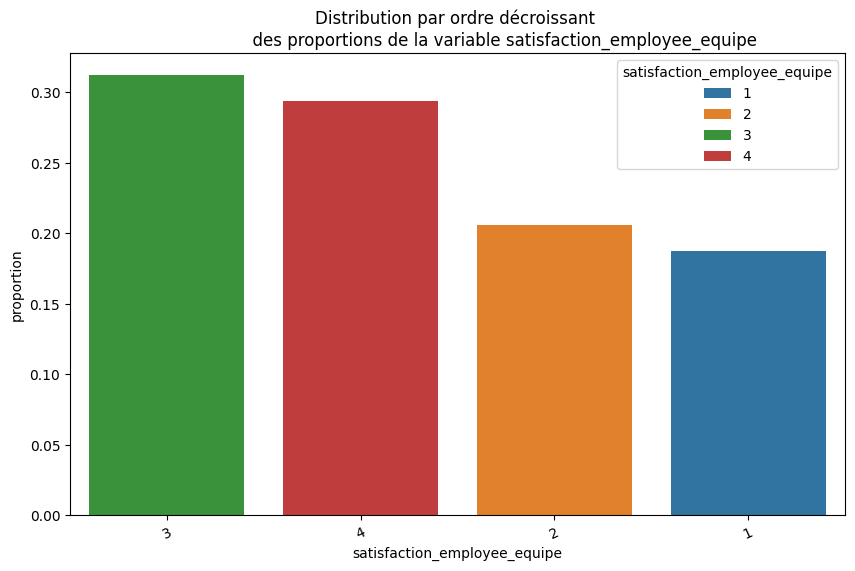

---------- Analyse de la variable : satisfaction_employee_equilibre_pro_perso ----------
Type de la variable : category
Nombre de valeurs uniques : 4
Valeurs uniques : [1, 3, 2, 4]
Categories (4, int64): [1, 2, 3, 4]
Statistiques descriptives :
count     1470
unique       4
top          3
freq       893
Name: satisfaction_employee_equilibre_pro_perso, dtype: int64
Distribution des valeurs :


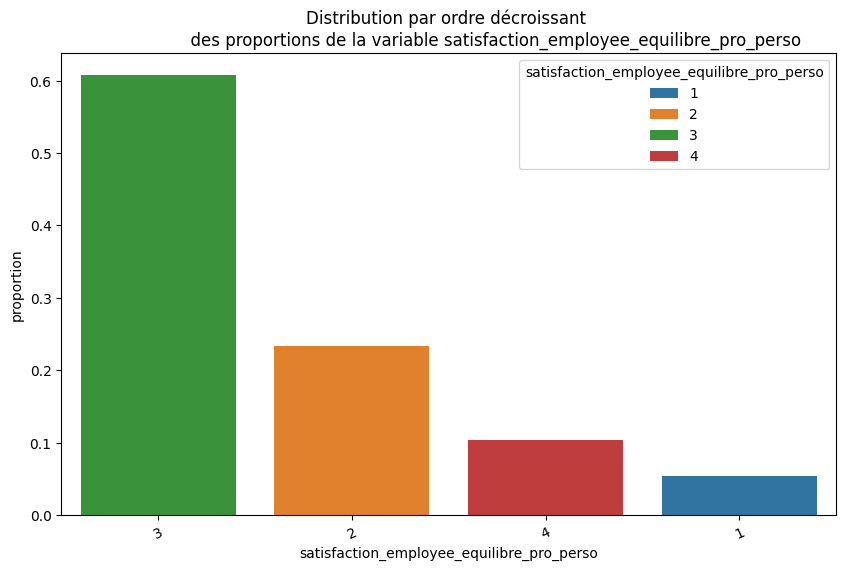

---------- Analyse de la variable : note_evaluation_actuelle ----------
Type de la variable : int64
Nombre de valeurs uniques : 2
Valeurs uniques : [3 4]
Statistiques descriptives :
count    1470.000000
mean        3.153741
std         0.360824
min         3.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: note_evaluation_actuelle, dtype: float64
Distribution des valeurs :


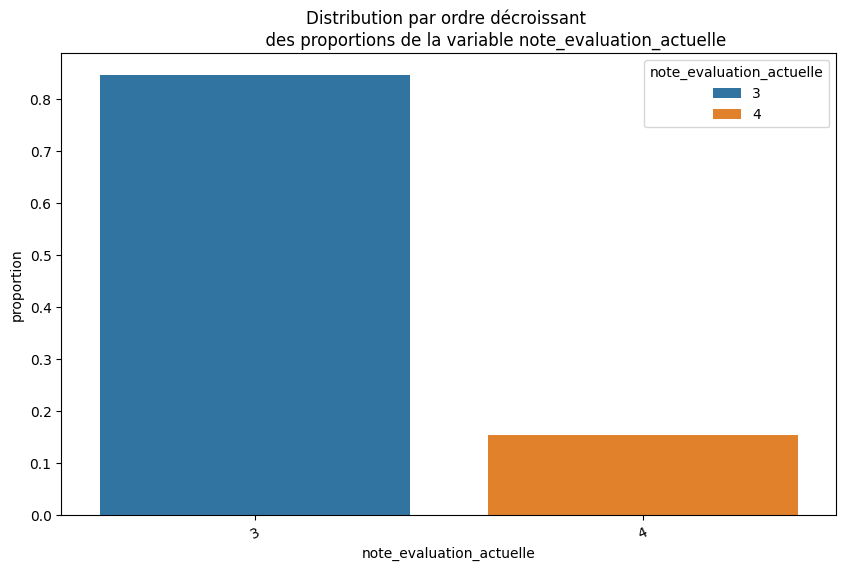

---------- Analyse de la variable : heure_supplementaires ----------
Type de la variable : category
Nombre de valeurs uniques : 2
Valeurs uniques : ['Oui', 'Non']
Categories (2, object): ['Non', 'Oui']
Statistiques descriptives :
count     1470
unique       2
top        Non
freq      1054
Name: heure_supplementaires, dtype: object
Distribution des valeurs :


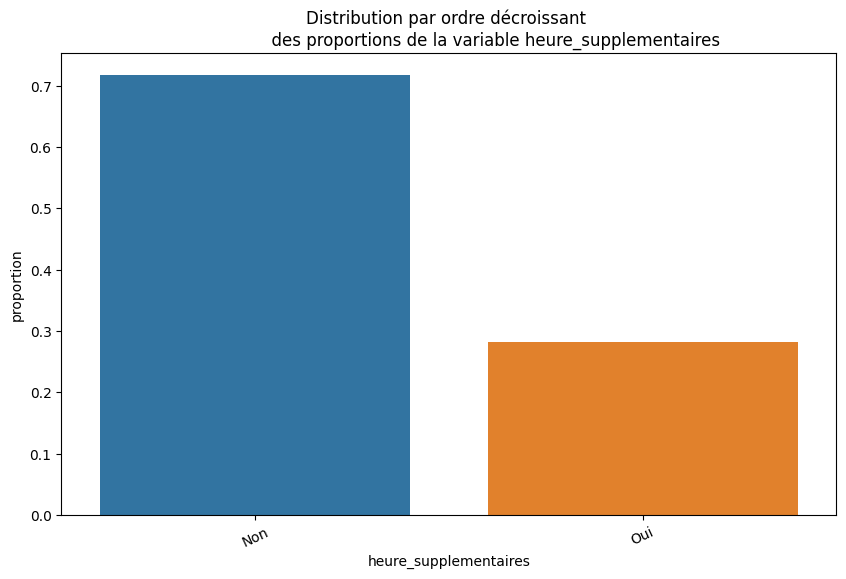

---------- Analyse de la variable : augmentation_salaire_precedente_pourc ----------
Type de la variable : int64
Nombre de valeurs uniques : 15
Valeurs uniques : [11 23 15 12 13 20 22 21 17 14 16 18 19 24 25]
Statistiques descriptives :
count    1470.000000
mean       15.209524
std         3.659938
min        11.000000
25%        12.000000
50%        14.000000
75%        18.000000
max        25.000000
Name: augmentation_salaire_precedente_pourc, dtype: float64
Distribution des valeurs :


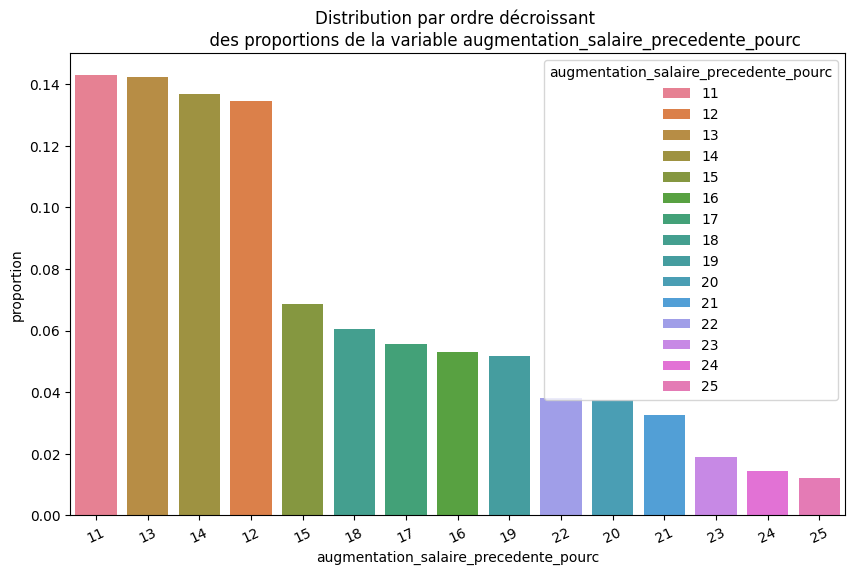

---------- Analyse de la variable : a_quitte_l_entreprise ----------
Type de la variable : category
Nombre de valeurs uniques : 2
Valeurs uniques : ['Oui', 'Non']
Categories (2, object): ['Non', 'Oui']
Statistiques descriptives :
count     1470
unique       2
top        Non
freq      1233
Name: a_quitte_l_entreprise, dtype: object
Distribution des valeurs :


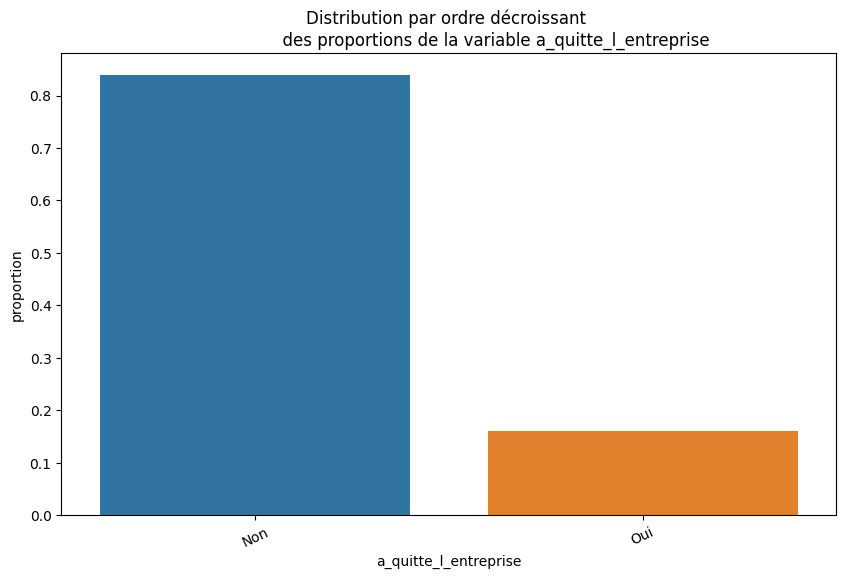

---------- Analyse de la variable : nombre_participation_pee ----------
Type de la variable : int64
Nombre de valeurs uniques : 4
Valeurs uniques : [0 1 3 2]
Statistiques descriptives :
count    1470.000000
mean        0.793878
std         0.852077
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: nombre_participation_pee, dtype: float64
Distribution des valeurs :


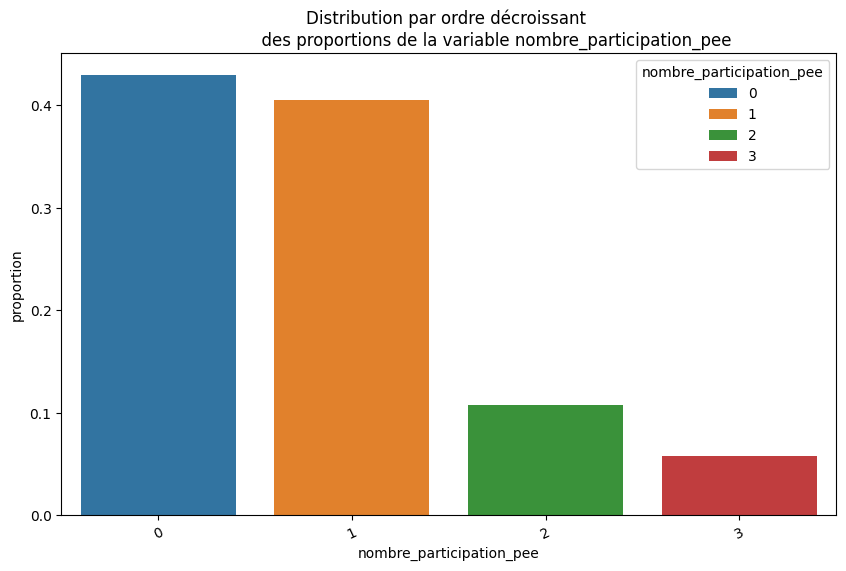

---------- Analyse de la variable : nb_formations_suivies ----------
Type de la variable : int64
Nombre de valeurs uniques : 7
Valeurs uniques : [0 3 2 5 1 4 6]
Statistiques descriptives :
count    1470.000000
mean        2.799320
std         1.289271
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         6.000000
Name: nb_formations_suivies, dtype: float64
Distribution des valeurs :


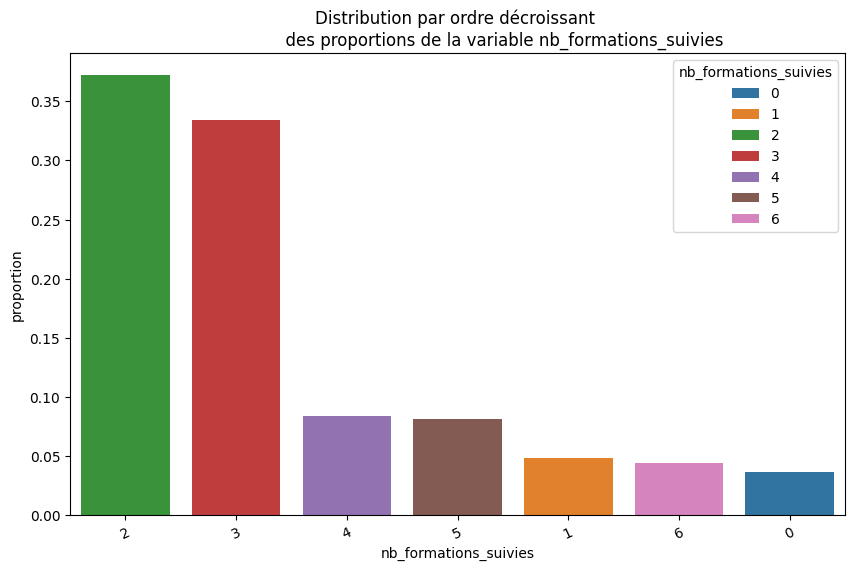

---------- Analyse de la variable : distance_domicile_travail ----------
Type de la variable : int64
Nombre de valeurs uniques : 29
Valeurs uniques : [ 1  8  2  3 24 23 27 16 15 26 19 21  5 11  9  7  6 10  4 25 12 18 29 22
 14 20 28 17 13]
Statistiques descriptives :
count    1470.000000
mean        9.192517
std         8.106864
min         1.000000
25%         2.000000
50%         7.000000
75%        14.000000
max        29.000000
Name: distance_domicile_travail, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

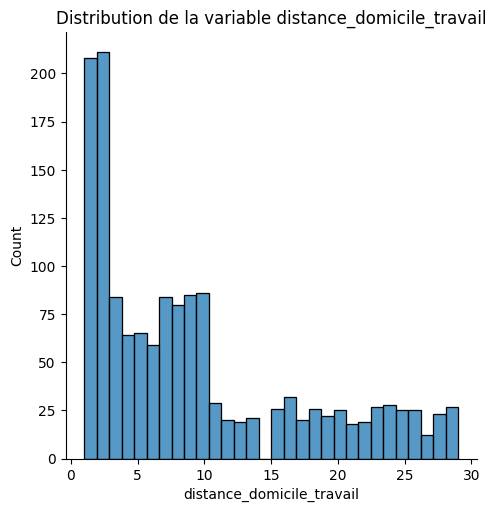

---------- Analyse de la variable : niveau_education ----------
Type de la variable : category
Nombre de valeurs uniques : 5
Valeurs uniques : [2, 1, 4, 3, 5]
Categories (5, int64): [1, 2, 3, 4, 5]
Statistiques descriptives :
count     1470
unique       5
top          3
freq       572
Name: niveau_education, dtype: int64
Distribution des valeurs :


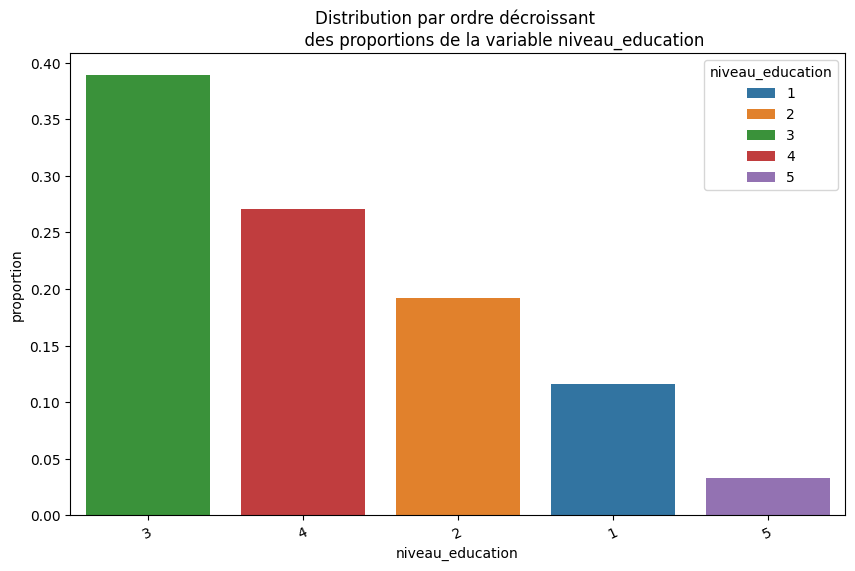

---------- Analyse de la variable : domaine_etude ----------
Type de la variable : category
Nombre de valeurs uniques : 6
Valeurs uniques : ['Infra & Cloud', 'Autre', 'Transformation Digitale', 'Marketing', 'Entrepreunariat', 'Ressources Humaines']
Categories (6, object): ['Autre', 'Entrepreunariat', 'Infra & Cloud', 'Marketing', 'Ressources Humaines', 'Transformation Digitale']
Statistiques descriptives :
count              1470
unique                6
top       Infra & Cloud
freq                606
Name: domaine_etude, dtype: object
Distribution des valeurs :


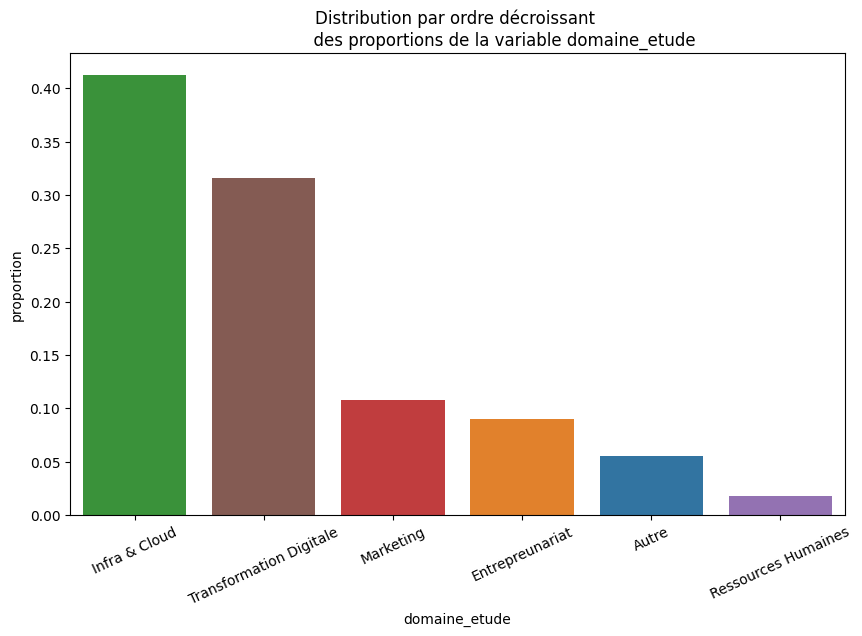

---------- Analyse de la variable : frequence_deplacement ----------
Type de la variable : category
Nombre de valeurs uniques : 3
Valeurs uniques : ['Occasionnel', 'Frequent', 'Aucun']
Categories (3, object): ['Aucun', 'Frequent', 'Occasionnel']
Statistiques descriptives :
count            1470
unique              3
top       Occasionnel
freq             1043
Name: frequence_deplacement, dtype: object
Distribution des valeurs :


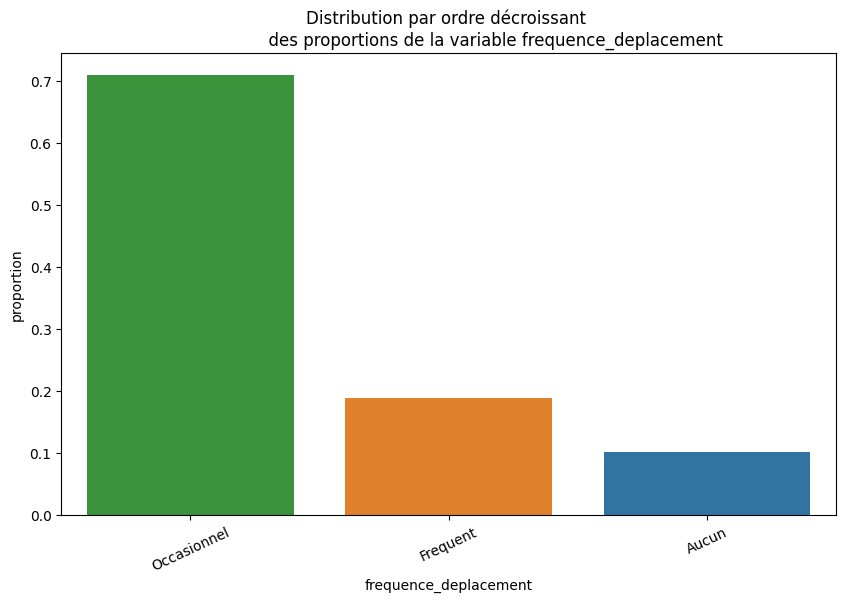

---------- Analyse de la variable : annees_depuis_la_derniere_promotion ----------
Type de la variable : int64
Nombre de valeurs uniques : 16
Valeurs uniques : [ 0  1  3  2  7  4  8  6  5 15  9 13 12 10 11 14]
Statistiques descriptives :
count    1470.000000
mean        2.187755
std         3.222430
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        15.000000
Name: annees_depuis_la_derniere_promotion, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

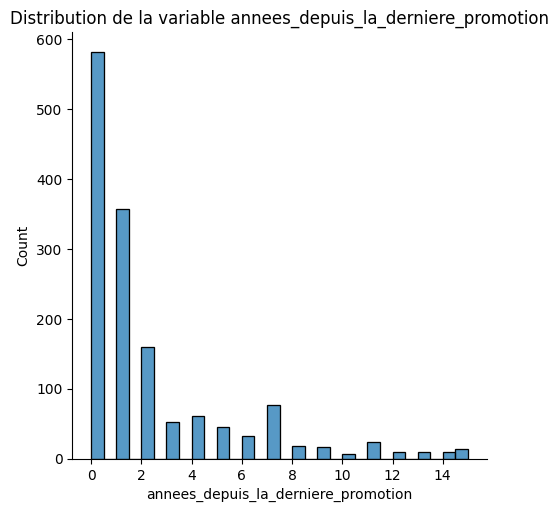

---------- Analyse de la variable : annes_sous_responsable_actuel ----------
Type de la variable : int64
Nombre de valeurs uniques : 18
Valeurs uniques : [ 5  7  0  2  6  8  3 11 17  1  4 12  9 10 15 13 16 14]
Statistiques descriptives :
count    1470.000000
mean        4.123129
std         3.568136
min         0.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        17.000000
Name: annes_sous_responsable_actuel, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

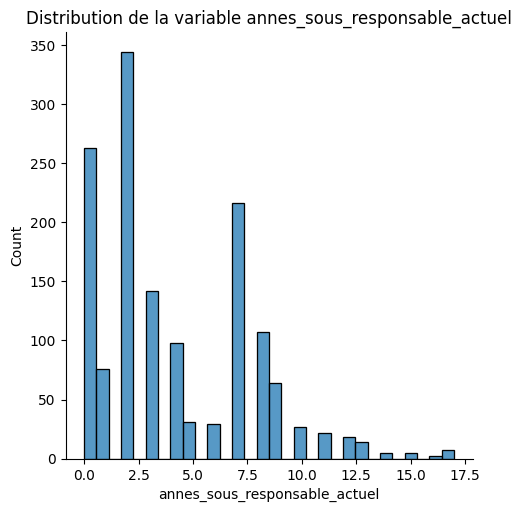

In [23]:
# nouvelle inspection 
EDA_de_table(df_master ,"df_master ",25)

## TRANSFORMATION DES VARIABLES ET ENCODAGE

Text(0.5, 1.0, 'Distribution du Revenu Mensuel APRES Log(1+x)')

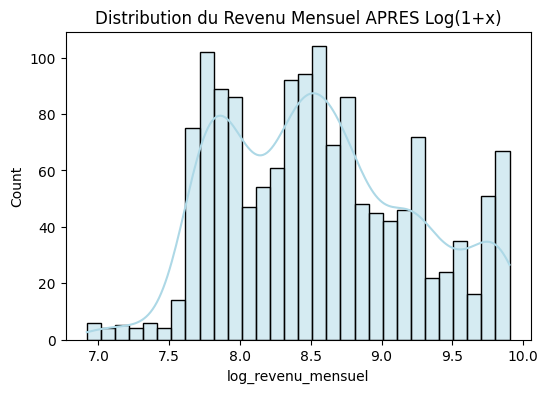

In [24]:
# Application de la transformation logarithmique à revenu_mensuel
# np.log1p utilise log(1+x), ce qui est plus stable
df_master['log_revenu_mensuel'] = np.log1p(df_master['revenu_mensuel'])

# Visualisation de la nouvelle distribution
plt.figure(figsize=(6, 4))
sns.histplot(df_master['log_revenu_mensuel'], kde=True, bins=30,color='lightblue')
plt.title('Distribution du Revenu Mensuel APRES Log(1+x)')

# Nous pourrions aussi imprimer l'asymétrie:
# original_skew = df_master['revenu_mensuel'].skew()  # ~1.8
# log_skew = df_master['log_revenu_mensuel'].skew()   # ~0.2 

In [25]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 1. Chargement et Feature Engineering
#df_master = pd.read_csv('df_master.csv')

# 2. Encodage de la variable cible (Oui: 1, Non: 0)
df_master['a_quitte_l_entreprise'] = df_master['a_quitte_l_entreprise'].map({'Oui': 1, 'Non': 0})

# Définition des groupes de colonnes
y = df_master['a_quitte_l_entreprise']
X = df_master.drop(columns=['a_quitte_l_entreprise'])

# Re-détermination des types après Feature Engineering
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['category']).columns.tolist()

# 3. Préparateur de Colonnes (ColumnTransformer)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)


In [26]:
# 4. Split des données (stratified pour préserver les proportions de la cible)
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y
)

In [27]:
# transformation et équilibrage des classes 
#importation SMOTE => rééquilibrage des classes 
from imblearn.over_sampling import SMOTE

# 1. Transformation des données d'entraînement et de test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# 2. Application de SMOTE UNIQUEMENT sur le jeu d'entraînement transformé
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

print("--- Proportions des classes après SMOTE ---")
print(y_train_res.value_counts(normalize=True))

--- Proportions des classes après SMOTE ---
a_quitte_l_entreprise
0    0.5
1    0.5
Name: proportion, dtype: float64


### MODELISATION ET ENTRAINEMENT : BASELINE MODEL 
#### Baseline model : regression logistique

--- Rapport de Classification ---
              precision    recall  f1-score   support

  Départ (0)       0.94      0.83      0.88       247
  Départ (1)       0.45      0.70      0.55        47

    accuracy                           0.81       294
   macro avg       0.69      0.77      0.71       294
weighted avg       0.86      0.81      0.83       294



Text(0.5, 1.0, 'Matrice de Confusion (Régression Logistique)')

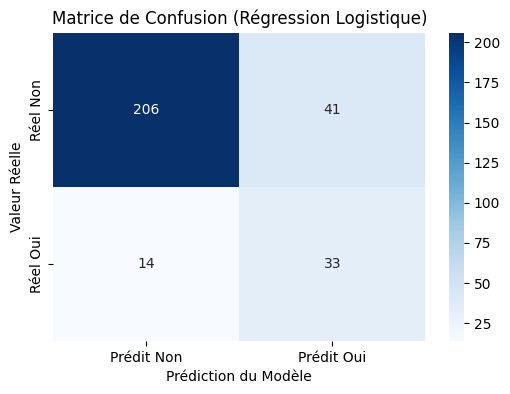

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


# 1. Entraînement du Modèle
# C est l'inverse de la force de régularisation. Une valeur plus faible régularise plus fort.
model_lr = LogisticRegression(random_state=42, solver='liblinear', C=1.0) 
model_lr.fit(X_train_res, y_train_res)

# 2. Prédiction sur le jeu de test (NON rééchantillonné)
y_pred = model_lr.predict(X_test_transformed)

# 3. Affichage du Rapport de Classification
print("--- Rapport de Classification ---")
print(classification_report(y_test, y_pred, target_names=['Départ (0)', 'Départ (1)']))

# 4. Affichage de la Matrice de Confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Prédit Non', 'Prédit Oui'], 
            yticklabels=['Réel Non', 'Réel Oui'])
plt.ylabel('Valeur Réelle')
plt.xlabel('Prédiction du Modèle')
plt.title('Matrice de Confusion (Régression Logistique)')
#plt.savefig('confusion_matrix_lr.png')

Le baseline model a 
- F1  : 55 % -on capture en général 55% de l'information
- Précision  : 45 % -On réussit à prédire 45% des cas de départ
- Rappel : 70 % Nous réussissons à capturer que 70% du pattern contenu dans les caractéristiques conduisant aux cas de départs rééls. 

### random forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
# (Les étapes de préparation des données (df_master, preprocessor, X_train_res, etc.) 
# sont supposées avoir été exécutées dans les blocs précédents pour la concision du code)

# 1. Entraînement du Modèle Random Forest
# Nous utilisons class_weight='balanced' pour aider le modèle à donner plus d'importance 
# à la classe minoritaire (Départ), renforçant l'effet de SMOTE ou agissant comme alternative.
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1) 
model_rf.fit(X_train_res, y_train_res)

# 2. Prédiction sur le jeu de test (NON rééchantillonné)
y_pred_rf = model_rf.predict(X_test_transformed)



--- Rapport de Classification Random Forest ---
                precision    recall  f1-score   support

Non-Départ (0)       0.87      0.98      0.92       247
    Départ (1)       0.65      0.23      0.34        47

      accuracy                           0.86       294
     macro avg       0.76      0.60      0.63       294
  weighted avg       0.83      0.86      0.83       294



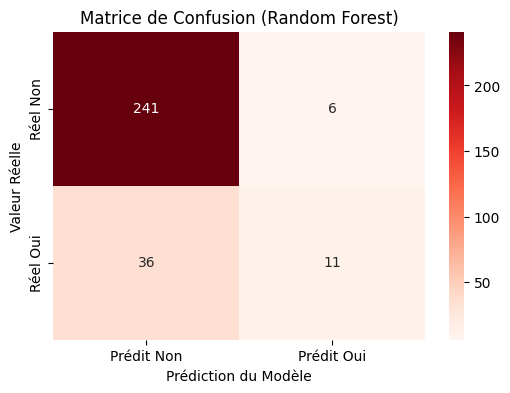

In [30]:
# Rapport de Classification
print("--- Rapport de Classification Random Forest ---")
print(classification_report(y_test, y_pred_rf, target_names=['Non-Départ (0)', 'Départ (1)']))

# Matrice de Confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Prédit Non', 'Prédit Oui'], 
            yticklabels=['Réel Non', 'Réel Oui'])
plt.ylabel('Valeur Réelle')
plt.xlabel('Prédiction du Modèle')
plt.title('Matrice de Confusion (Random Forest)')
plt.savefig('confusion_matrix_rf.png')

--- Rapport de Classification Gradient Boosting ---
                precision    recall  f1-score   support

Non-Départ (0)       0.86      0.97      0.91       247
    Départ (1)       0.53      0.19      0.28        47

      accuracy                           0.84       294
     macro avg       0.70      0.58      0.60       294
  weighted avg       0.81      0.84      0.81       294



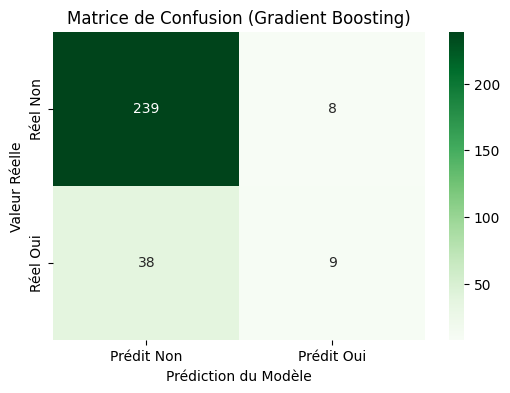

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier # Changement de modèle
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns




# --- 2. Entraînement et Évaluation du GBM ---
# Utilisation de paramètres de base pour un premier essai rapide
model_gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) 
model_gbm.fit(X_train_transformed, y_train)

# Prédiction
y_pred_gbm = model_gbm.predict(X_test_transformed)

# Rapport de Classification
print("--- Rapport de Classification Gradient Boosting ---")
print(classification_report(y_test, y_pred_gbm, target_names=['Non-Départ (0)', 'Départ (1)']))

# Matrice de Confusion
cm_gbm = confusion_matrix(y_test, y_pred_gbm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gbm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Prédit Non', 'Prédit Oui'], 
            yticklabels=['Réel Non', 'Réel Oui'])
plt.ylabel('Valeur Réelle')
plt.xlabel('Prédiction du Modèle')
plt.title('Matrice de Confusion (Gradient Boosting)')
plt.savefig('confusion_matrix_gbm.png')

In [33]:
# xgboost 
#%pip install xgboost 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier # Import du modèle XGBoost
from sklearn.metrics import classification_report, confusion_matrix




# --- 2. Calcul du Poids pour l'Imbalance ---
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count
print(f"Scale Pos Weight calculé (Non/Oui) : {scale_pos_weight_value:.2f}")


# --- 3. Entraînement et Évaluation du Modèle XGBoost ---
model_xgb = XGBClassifier(
    objective='binary:logistic',
    #use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_value, # Gestion du déséquilibre
    random_state=42
)
model_xgb.fit(X_train_transformed, y_train)
y_pred_xgb = model_xgb.predict(X_test_transformed)

print("\n--- Rapport de Classification XGBoost (Baseline) ---")
print (classification_report(y_test, y_pred_xgb, target_names=['Non-Départ (0)', 'Départ (1)']))

Scale Pos Weight calculé (Non/Oui) : 5.19

--- Rapport de Classification XGBoost (Baseline) ---
                precision    recall  f1-score   support

Non-Départ (0)       0.88      0.96      0.92       247
    Départ (1)       0.61      0.30      0.40        47

      accuracy                           0.86       294
     macro avg       0.74      0.63      0.66       294
  weighted avg       0.84      0.86      0.84       294



In [ ]:
# a tester scikit learn deep learning model ou keras 

In [77]:

from sklearn.neural_network import MLPClassifier # Le modèle Deep Learning de Scikit-learn
from sklearn.metrics import classification_report

# --- 2. Création et Entraînement du Modèle MLP ---
# Configuration simple : un calque caché (hidden_layer_sizes=(50,)), 300 itérations max
model_mlp = MLPClassifier(
    hidden_layer_sizes=(10,10,5,5,),
    activation='relu',            
    solver='adam',
    max_iter=300,                 
    random_state=42
)

# Entraînement sur les données transformées et scalées
print("Entraînement du modèle MLP...")
model_mlp.fit(X_train_transformed, y_train)


# --- 3. Évaluation du Modèle ---
y_pred_mlp = model_mlp.predict(X_test_transformed)
print("\n--- Rapport de Classification MLP (Réseau de Neurones) ---")
print(classification_report(y_test, y_pred_mlp, target_names=['Non-Départ (0)', 'Départ (1)']))

Entraînement du modèle MLP...

--- Rapport de Classification MLP (Réseau de Neurones) ---
                precision    recall  f1-score   support

Non-Départ (0)       0.91      0.91      0.91       247
    Départ (1)       0.52      0.51      0.52        47

      accuracy                           0.85       294
     macro avg       0.71      0.71      0.71       294
  weighted avg       0.85      0.85      0.85       294



/usr/local/bin/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
